# W266 Final Project - Testing Out Longformer Model

**Description:** 

- This notebook tests out the performance of the longformer model, presented in "Longformer: The Long-Document Transformer" by Iz Beltagy, Matthew E. Peters, Arman Cohan (https://arxiv.org/abs/2004.05150).
- The model was pre-trained for MDS (multi-document summarization) in the PRIMERA model (vide "PRIMERA: Pyramid-based Masked Sentence Pre-training for Multi-document Summarization" at https://arxiv.org/abs/2110.08499).

## Setup

In [1]:
import evaluate
from pprint import pprint

## For printing out model summary in PyTorch
from torchvision import models
from torchsummary import summary

## General plotting
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Managing memory
import gc
import pickle

## Text processing
import re
import numpy as np
from scipy import stats as st

In [2]:
from datasets import load_dataset, load_metric

In [3]:
## Checking if GPU is available when running locally
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



## 1. Importing Longformer Model

### 1.1 Preliminaries

- Uses the HuggingFace model (https://huggingface.co/docs/transformers/model_doc/led).  This is the model with both encoder and decoder, and trained on summarization task using the arxiv dataset.
- The encoder only version is at https://huggingface.co/docs/transformers/model_doc/longformer).

In [4]:
## Importing model
from transformers import LEDModel, LEDConfig, LEDTokenizer, AutoTokenizer, LEDForConditionalGeneration, EncoderDecoderModel

In [5]:
## Loading check point

LEDmodel = LEDForConditionalGeneration.from_pretrained("allenai/led-large-16384-arxiv").to("cuda").half()
LEDtokenizer = AutoTokenizer.from_pretrained("allenai/led-large-16384-arxiv")

# LEDtokenizer2 = LEDTokenizer.from_pretrained("allenai/led-large-16384-arxiv")

# LEDmodel = LEDModel.from_pretrained("allenai/led-base-16384")
# LEDtokenizer = LEDTokenizer.from_pretrained("allenai/led-base-16384")

In [6]:
## Loading rouge
rouge = load_metric("rouge")

C:\Users\JustinTo\AppData\Local\Temp\ipykernel_15872\4286193646.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


### 1.2 Model summary and config

In [7]:
## Summary of model
print(summary(LEDmodel))

Layer (type:depth-idx)                             Param #
├─LEDModel: 1-1                                    --
|    └─Embedding: 2-1                              51,471,360
|    └─LEDEncoder: 2-2                             --
|    |    └─Embedding: 3-1                         (recursive)
|    |    └─LEDLearnedPositionalEmbedding: 3-2     16,777,216
|    |    └─ModuleList: 3-3                        188,940,288
|    |    └─LayerNorm: 3-4                         2,048
|    └─LEDDecoder: 2-3                             --
|    |    └─Embedding: 3-5                         (recursive)
|    |    └─LEDLearnedPositionalEmbedding: 3-6     1,048,576
|    |    └─ModuleList: 3-7                        201,560,064
|    |    └─LayerNorm: 3-8                         2,048
├─Linear: 1-2                                      51,471,360
Total params: 511,272,960
Trainable params: 511,272,960
Non-trainable params: 0
Layer (type:depth-idx)                             Param #
├─LEDModel: 1-1            

In [180]:
## Seeing the configuration options.

config = LEDConfig.from_pretrained("allenai/led-large-16384-arxiv")
# config = LEDConfig.from_pretrained("allenai/led-base-16384")
config

LEDConfig {
  "_name_or_path": "./",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_decoder_po

### 1.3 Tests using manual examples

- To try out selected manually prepared examples, just to get a feel of how the model behaves.

#### 1.3.1 Example 1 - Sample text from Arxiv (from HuggingFace example)
- Somehow, the model just extracts a sentence without much major change.

In [68]:
ARTICLE_TO_SUMMARIZE = '''Transformers (Vaswani et al., 2017) have achieved state-of-the-art
    results in a wide range of natural language tasks including generative language modeling
    (Dai et al., 2019; Radford et al., 2019) and discriminative ... language understanding (Devlin et al., 2019).
    This success is partly due to the self-attention component which enables the network to capture contextual
    information from the entire sequence. While powerful, the memory and computational requirements of
    self-attention grow quadratically with sequence length, making it infeasible (or very expensive) to
    process long sequences. To address this limitation, we present Longformer, a modified Transformer
    architecture with a self-attention operation that scales linearly with the sequence length, making it
    versatile for processing long documents (Fig 1). This is an advantage for natural language tasks such as
    long document classification, question answering (QA), and coreference resolution, where existing approaches
    partition or shorten the long context into smaller sequences that fall within the typical 512 token limit
    of BERT-style pretrained models. Such partitioning could potentially result in loss of important
    cross-partition information, and to mitigate this problem, existing methods often rely on complex
    architectures to address such interactions. On the other hand, our proposed Longformer is able to build
    contextual representations of the entire context using multiple layers of attention, reducing the need for
    task-specific architectures.'''
inputs = LEDtokenizer(ARTICLE_TO_SUMMARIZE, return_tensors="pt")

global_attention_mask = torch.zeros_like(inputs['attention_mask'])
global_attention_mask[:, 0] = 1

predicted_abstract_ids = LEDmodel.generate(inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'], 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=48, 
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' we present a modified version of the transformer ( vaswani et al. \n, 2017 ) architecture with a self-attention operation that scales linearly with the sequence length, making it versatile for processing long documents.']

#### 1.3.2 Example 2 - Training examplen from Multinews (Part 1)
- Somehow, the model just extracts a sentence without much major change.
- Correct summary is: **"– The unemployment rate dropped to 8.2% last month, but the economy only added 120,000 jobs, when 203,000 new jobs had been predicted, according to today's jobs report. Reaction on the Wall Street Journal's MarketBeat Blog was swift: "Woah!!! Bad number." The unemployment rate, however, is better news; it had been expected to hold steady at 8.3%. But the AP notes that the dip is mostly due to more Americans giving up on seeking employment."** *(74 words)*
- The answer is quite far-off, without much mentioning of the key job figures.
- Note that for Multi-news, the " ||||| " probably signals the start of another article.
- If we follow the PRIMERA paper, this symbol should probably be replaced by special tokens and be given global (instead of local) attention.

In [74]:
ARTICLE_TO_SUMMARIZE = '''National Archives Yes, it’s that time again, folks. 
It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,
Washington and Main Street are all aligned on one thing: Jobs. A fresh update on the U.S. employment
situation for January hits the wires at 8:30 a.m. New York time offering one of the most important 
snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs 
to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added
in February. The unemployment rate is expected to hold steady at 8.3%. Here at MarketBeat HQ, we’ll be
offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself,
via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. 
Enjoy the show. ||||| Employers pulled back sharply on hiring last month, a reminder that the U.S. 
economy may not be growing fast enough to sustain robust job growth. The unemployment rate dipped, 
but mostly because more Americans stopped looking for work. The Labor Department says the economy added 
120,000 jobs in March, down from more than 200,000 in each of the previous three months. The unemployment 
rate fell to 8.2 percent, the lowest since January 2009. The rate dropped because fewer people searched 
for jobs. The official unemployment tally only includes those seeking work. The economy has added 858,000 
jobs since December _ the best four months of hiring in two years. But Federal Reserve Chairman Ben Bernanke 
has cautioned that the current hiring pace is unlikely to continue without more consumer spending.'''
inputs = LEDtokenizer(ARTICLE_TO_SUMMARIZE, return_tensors="pt")

global_attention_mask = torch.zeros_like(inputs['attention_mask'])
global_attention_mask[:, 0] = 1

predicted_abstract_ids = LEDmodel.generate(inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'], 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=128, 
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' this is a preview of our live coverage of the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,Washington and Main Street are all aligned on one thing: Jobs.  it will be our pleasure to provide color commentary before and after the data crosses the wires at 8:30 a.m. New York time offering one of the most important snapshots on how the economy fared during the previous month. Feel free to weigh-in yourself,via the comments section.  enjoy the show. ']

#### 1.3.2 Example 2 - Part 2
- And interestingly, if we remove the " ||||| " part, the model just fails to perform normally.

In [75]:
ARTICLE_TO_SUMMARIZE = '''National Archives Yes, it’s that time again, folks. 
It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,
Washington and Main Street are all aligned on one thing: Jobs. A fresh update on the U.S. employment
situation for January hits the wires at 8:30 a.m. New York time offering one of the most important 
snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs 
to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added
in February. The unemployment rate is expected to hold steady at 8.3%. Here at MarketBeat HQ, we’ll be
offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself,
via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. 
Enjoy the show. Employers pulled back sharply on hiring last month, a reminder that the U.S. 
economy may not be growing fast enough to sustain robust job growth. The unemployment rate dipped, 
but mostly because more Americans stopped looking for work. The Labor Department says the economy added 
120,000 jobs in March, down from more than 200,000 in each of the previous three months. The unemployment 
rate fell to 8.2 percent, the lowest since January 2009. The rate dropped because fewer people searched 
for jobs. The official unemployment tally only includes those seeking work. The economy has added 858,000 
jobs since December _ the best four months of hiring in two years. But Federal Reserve Chairman Ben Bernanke 
has cautioned that the current hiring pace is unlikely to continue without more consumer spending.'''
inputs = LEDtokenizer(ARTICLE_TO_SUMMARIZE, return_tensors="pt")

global_attention_mask = torch.zeros_like(inputs['attention_mask'])
global_attention_mask[:, 0] = 1

predicted_abstract_ids = LEDmodel.generate(inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'], 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=128, 
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' it is that time of the month again, when for one ever-so-brief moment the interests of Wall Street,Washington and Main Street are all aligned on one thing: Jobs.  it is the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,Washington and Main Street are all aligned on one thing: Jobs.  it is the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,Washington and Main Street are all aligned on one thing: Jobs.  it is the first Friday of the month, when']

#### 1.3.2 Example 2 - Part 3
- Now we try to actually separate the two articles, give each of them a proper global attention leading token, concatenate them again, and see how the model responds.
- The answer seems much more reasonable, though towards the end some random tokens are spit out.

In [95]:
ARTICLE_TO_SUMMARIZE = '''National Archives Yes, it’s that time again, folks. 
It’s the first Friday of the month, when for one ever-so-brief moment the interests of Wall Street,
Washington and Main Street are all aligned on one thing: Jobs. A fresh update on the U.S. employment
situation for January hits the wires at 8:30 a.m. New York time offering one of the most important 
snapshots on how the economy fared during the previous month. Expectations are for 203,000 new jobs 
to be created, according to economists polled by Dow Jones Newswires, compared to 227,000 jobs added
in February. The unemployment rate is expected to hold steady at 8.3%. Here at MarketBeat HQ, we’ll be
offering color commentary before and after the data crosses the wires. Feel free to weigh-in yourself,
via the comments section. And while you’re here, why don’t you sign up to follow us on Twitter. 
Enjoy the show. ||||| Employers pulled back sharply on hiring last month, a reminder that the U.S. 
economy may not be growing fast enough to sustain robust job growth. The unemployment rate dipped, 
but mostly because more Americans stopped looking for work. The Labor Department says the economy added 
120,000 jobs in March, down from more than 200,000 in each of the previous three months. The unemployment 
rate fell to 8.2 percent, the lowest since January 2009. The rate dropped because fewer people searched 
for jobs. The official unemployment tally only includes those seeking work. The economy has added 858,000 
jobs since December _ the best four months of hiring in two years. But Federal Reserve Chairman Ben Bernanke 
has cautioned that the current hiring pace is unlikely to continue without more consumer spending.'''

part1, part2 = ARTICLE_TO_SUMMARIZE.split(" ||||| ")[0], ARTICLE_TO_SUMMARIZE.split(" ||||| ")[1]

inputs1 = LEDtokenizer(part1, return_tensors="pt")
inputs2 = LEDtokenizer(part2, return_tensors="pt")

global_attention_mask1 = torch.zeros_like(inputs1['attention_mask'])
global_attention_mask1[:, 0] = 1

global_attention_mask2 = torch.zeros_like(inputs2['attention_mask'])
global_attention_mask2[:, 0] = 1

inputs=torch.concat((inputs1['input_ids'], inputs2['input_ids']), 1)
attention_mask=torch.concat((inputs1['attention_mask'], inputs2['attention_mask']), 1)
global_attention_mask=torch.concat((global_attention_mask1, global_attention_mask2), 1)

predicted_abstract_ids = LEDmodel.generate(inputs,
                                           attention_mask=attention_mask, 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=128, 
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' we present a preview of the economic data for the month of january, which will be released at 8:30 a.m. New York time. \n we will focus on the job creation report for the month of january, which is expected to show 203,000 new jobs added in the month of january, compared to 227,000 jobs added in the previous month. \n the unemployment rate is expected to hold steady at 8.3%.    \n # 1_#1 _ # 1_#1 _ =    # 1 1.25 in.125 in.25 in']

#### 1.3.3 Example 3 - A longer training examplen from Multinews (Part 1)
- Since LED is about "long" inputs, let's see how it behaves for a longer article.
- Correct summary is: **"– A twin-engine Embraer jet that the FAA describes as "on approach to Runway 14" at the Montgomery County Airpark in Gaithersburg, Maryland, crashed into a home this morning, engulfing that home in flames and setting two others on fire. Three people are dead, but the count could grow. A Montgomery County Fire rep says three fliers were killed in the crash, but notes the corporate plane may have had a fourth person on board, reports the AP. A relative of the owner of the home that was hit tells WUSA 9 that a mother with three children pre-school age and under should have been home at the time; there's no word on the family's whereabouts. The crash occurred around 11am on Drop Forge Lane, and the fire was extinguished within an hour. Crews are now searching the wreckage. A witness noted the plane appeared to "wobble" before the crash; the airport is no more than 3/4 mile from the crash scene. NTSB and FAA will investigate."**  *(166 words)*
- First, we try it without breaking up anything.
- Somehow the model is able to generate some relevant text but can't use up the word limit.  There are also strange texts towards the end.

In [98]:
ARTICLE_TO_SUMMARIZE = '''GAITHERSBURG, Md. (AP) — A small, private jet has crashed into
a house in Maryland's Montgomery County on Monday, killing at least three people on board,
authorities said. Preliminary information indicates at least three people were on board and
didn't survive the Monday crash into home in Gaithersburg, a Washington, D.C. suburb, said
Pete Piringer, a Montgomery County Fire and Rescue spokesman. He said a fourth person may have
been aboard. Piringer said the jet crashed into one home around 11 a.m., setting it and two
others on fire. Crews had the fire under control within an hour and were searching for anyone
who may have been in the homes. Television news footage of the scene showed one home nearly destroyed,
with a car in the driveway. Witnesses told television news crews that they saw the airplane appear
to struggle to maintain altitude before going into a nosedive and crashing. An FAA spokesman said
preliminary information shows the Embraer EMB-500/Phenom 100 twin-engine jet was on approach at the
nearby Montgomery County Airpark. The National Transportation Safety Board is sending an investigator
to the scene. ||||| Gemmell family (Photo: Facebook) GAITHERSBURG, Md. (WUSA9) -- The investigations 
into a plane crash that left six people dead in Gaithersburg on Monday evening are just beginning. 
A mother and her two young children are three of the six lives lost in the crash. Marie Gemmell, 36,
her three-year-old son Cole and her infant-son Devin were inside their home when a corporate jet crashed
into it. Their bodies were found on the second floor hours after the crash. The father and a third child
were not home at the time of the crash. Michael Rosenberg was on the jet that crashed (Photo: Health Decisions)
Three people on the jet were also killed, according to Montgomery County fire officials. One of those victims
has been identified as Michael Rosenberg, CEO of Health Decisions. You can read their statement here. An Embraer
EMB-500/Phenom 100 crashed into a house in the 19700 block of Drop Forge Lane off Snouffer School Road in the 
neighborhood of Hunters Woods around 10:45 a.m., according to the NTSB. The plane was coming from Chapel Hill, 
NC and approaching the Montgomery County Air Park. The NTSB has sent a go-team to the site, where three homes 
were damaged. Firefighters used foam to battle fires all around the scene. The fuselage of the jet is parallel 
to a second house, and the tail of the airplane is at the front door. One of the wings was catapulted into the 
Gemmell's house, causing a huge fire and the majority of the damage, according to the NTSB. Senior Investigator 
Timothy LeBaron is leading the go-team. Investigators are looking at operations, including crew experience, training
and procedures, the functionality of the engines, the weather, air traffic control and more, NTSB spokesperson 
Robert L. Sumwalt said at a press confrence. "Our mission is to find out not only what happened, but why it happened
because we want to make sure something like this never happens again," Sumwalt said. MORE: Woman says community feared
plane crash NTSB investigators are currently collecting perishable evidence, not determining the cause. They'll be
conducting interviews and documenting the wreckage. Investigators could be on the scene for three to seven days for
what they call the "fact-finding" phase. The black box, which has recordings from the crash, has been recovered. It
is in good condition and has been rushed to labs, Sumwalt said. The first call about the crash came in at 10:44 a.m.
from the National Guard Armory for the report of an explosion, and units were on the scene in approximately seven 
minutes, Montgomery County Fire Chief Steve Lohr said at an initial press conference. Utility crews were also on the
scene and Lorh said it is safe for residents in the area. Electricity has been temporarily cut off. Recordings of the
911-calls from the crash were released on Monday evening. In the recordings neighbors and witnesses describe the scene
where the plane crashed in the Gaithersburg neighborhood. Recordings of the 911 calls from the Gaithersburg plane crash
were released on Monday evening. "We just heard a giant explosion we looked out the window and there's... it looks 
like a house is on fire, we've got some people running over there to see if people are okay," one caller described. 
RAW: Fire Chief Steve Lohr speaks on plane crash A woman who was traveling into the area after taking a test at 
Montgomery College tells WUSA9 that she could see the smoke from the crash from I-370. As she got closer, she saw all
the emergency response vehicles and called her husband. He told her that the smoke was coming from the area where her
mother and stepfather lived and she says she got worried. She discovered the house that was struck was their neighbors'
house. She says there are "three little ones" who live in that house. One person reported seeing the plane "wobble"
before it crashed into the house. Other neighbors reported hearing repeated booms and feeling their houses shake 
from the impact of the plane. Something went wrong with the jet heading to the Montgomery County airport and it went
into a house in Gaithersburg WUSA9 spoke with an eyewitness named Jocelyn Brown who said she first heard the plane 
sputtering, making a sound that planes that go over the area normally don't make flying over the houses. She says she
and her mother became concerned and went to investigate. They then saw the plane hit the side of a house. She reported
seeing a "mushroom effect of smoke" and also hearing three explosions after the plane hit. Jocelyn says they also heard
screams in the area of the home. She says she does not know whether they were coming from inside the house or behind
them. Jocelyn lives in the area and says she knows the mother that lives there. She described her as a "sweet woman"
who walks with her kids in the area all the time and speaks to everyone. He said the plane sounded like it was
"puttering" and then saw fire A woman posted video from the ground of the scene of the plane crash on YouTube. . 
The FAA has released the following information: "This is preliminary information about an Embraer EMB-500/Phenom 100
twin-engine jet that crashed one mile north of the Montgomery County Airport, Gaithersburg, MD at 11am today. The 
aircraft was on approach to Runway 14 at the airport when the accident occurred. Please contact local authorities 
for information on passengers and the situation on the ground. The FAA will investigate. We will update this statement
when new information is available. " Photo of plane from FlightAware (Photo: FlightAware) An FAA source says the jet 
was waiting for a much slower single engine aircraft, possibly a Cessna, to make its turn so it could make its approach.
That information has not been confirmed by the NTSB. The Montgomery County Air Park is within 1/2 to 3/4 of a mile of 
the crash. The airport does not have a tower, so communication would have been with Washington Air Traffic Control 
Section, not the airport. The FAA registry shows that the plane was a corporate Phenom jet with tail number N100EQ. 
It's registered to Sage Aviation LLC out of Chapel Hill, NC which makes replacement parts for the aviation industry. 
MORE: Gaithersburg plane crash at Drop Forge Lane, 3 houses suffering some sort of damage, this one the worst
@WNEWpic.twitter.com/vihz4k5eYE — JimMacKayWNEW (@JimMacKayWNEW) December 8, 2014 Snouffer School Road was closed 
between Centerway Road and Goshen Road following the crash. Drivers and pedestrians are being urged to avoid the area.
It is likely to remain closed throughout the night and possibly Tuesday. She says something has to be done about 
planes flying low directly over homes. Read or Share this story: http://on.wusa9.com/1A8PzKE"'''
inputs = LEDtokenizer(ARTICLE_TO_SUMMARIZE, return_tensors="pt")

global_attention_mask = torch.zeros_like(inputs['attention_mask'])
global_attention_mask[:, 0] = 1

predicted_abstract_ids = LEDmodel.generate(inputs['input_ids'],
                                           attention_mask=inputs['attention_mask'], 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=200, # Customized in view of the length of the reference summary
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' the investigation into a plane crash that left six people dead in Gaithersburg on Monday evening is just beginning. \n a mother and her two young children are three of the six lives lost in the crash. Something went wrong with the jet heading to the Montgomery County airport and it went into a house in Gaithersburg, a Washington, D.C. suburb. \n three people on the jet were also killed, according to Montgomery County fire officials. \n the plane was coming from Chapel Hill,  \n NC and approaching the Montgomery County Air Park.    \n # 1_#1 _ # 1_#1 _ =    # 1 1.25 in.125 in.25 in ']

#### 1.3.3 Example 3 (Part 2)
- Since the out put was quite a bit shorter than the reference, I have tried adding in a "min_length" parameter which is not in the configuration.  Naturally, it seems to do nearly nothing.

In [106]:
predicted_abstract_ids2 = LEDmodel.generate(inputs['input_ids'],
                                            attention_mask=inputs['attention_mask'], 
                                            global_attention_mask=global_attention_mask, 
                                            min_length=150, # min_length is not a config and seems to do nothing
                                            max_length=200, 
                                            num_beams=4)

LEDtokenizer.batch_decode(predicted_abstract_ids2, skip_special_tokens=True)

[' the investigation into a plane crash that left six people dead in Gaithersburg on Monday evening is just beginning. \n a mother and her two young children are three of the six lives lost in the crash. Something went wrong with the jet heading to the Montgomery County airport and it went into a house in Gaithersburg, a Washington, D.C. suburb. \n three people on the jet were also killed, according to Montgomery County fire officials. \n the plane was coming from Chapel Hill, \n NC and approaching the Montgomery County Air Park when it crashed into the house.    \n # 1_#1 _ # 1_#1 _ =    # 1 1.25 in.125 in.25 in ']

#### 1.3.3 Example 3 (Part 3)
- Let's try doing the split once more.
- Result is no good.  Perhaps we really need the \<doc-sep> token?  But that is not included in the LED tokenizer

In [109]:
part1, part2 = ARTICLE_TO_SUMMARIZE.split(" ||||| ")[0], ARTICLE_TO_SUMMARIZE.split(" ||||| ")[1]

inputs1 = LEDtokenizer(part1, return_tensors="pt")
inputs2 = LEDtokenizer(part2, return_tensors="pt")

global_attention_mask1 = torch.zeros_like(inputs1['attention_mask'])
global_attention_mask1[:, 0] = 1

global_attention_mask2 = torch.zeros_like(inputs2['attention_mask'])
global_attention_mask2[:, 0] = 1

inputs=torch.concat((inputs1['input_ids'], inputs2['input_ids']), 1)
attention_mask=torch.concat((inputs1['attention_mask'], inputs2['attention_mask']), 1)
global_attention_mask=torch.concat((global_attention_mask1, global_attention_mask2), 1)

predicted_abstract_ids = LEDmodel.generate(inputs,
                                           attention_mask=attention_mask, 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=200, 
                                           num_beams=4)

predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' a small, private jet has crashed into a house in the neighborhood of Hunters Woods on Monday morning, killing at least three people on board. \n the plane was on approach to the Montgomery County airport when it crashed into the house.    \n # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3']

In [41]:
## There is no <doc-sep> token in the LED tokenizer
LEDtokenizer("<doc-sep>", return_tensors="pt")

{'input_ids': tensor([[    0, 41552, 37447,    12,  1090,   642, 15698,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
## But it is present in the PRIMERA one
PRIMERAtokenizer = AutoTokenizer.from_pretrained('allenai/PRIMERA')

PRIMERAtokenizer("<doc-sep>", return_tensors="pt")

{'input_ids': tensor([[    0, 50265,     2]]), 'attention_mask': tensor([[1, 1, 1]])}

#### 1.3.3 Example 3 (Part 4)
- Perhaps let's try using the PRIMERA tokenizer.
- First, we try out the use of the tokenizer normally, i.e. without adding the \<doc-sep> token.
- Then we try adding in the \<doc-sep> token which is supported by the tokenizer.

In [126]:
## Experimenting with just the PRIMERA tokenizer first.  Answer seems to be that there is no effect whatsoever.
part1, part2 = ARTICLE_TO_SUMMARIZE.split(" ||||| ")[0], ARTICLE_TO_SUMMARIZE.split(" ||||| ")[1]

inputs1 = PRIMERAtokenizer(part1, return_tensors="pt")
inputs2 = PRIMERAtokenizer(part2, return_tensors="pt")

global_attention_mask1 = torch.zeros_like(inputs1['attention_mask'])
global_attention_mask1[:, 0] = 1

global_attention_mask2 = torch.zeros_like(inputs2['attention_mask'])
global_attention_mask2[:, 0] = 1

inputs=torch.concat((inputs1['input_ids'], inputs2['input_ids']), 1)
attention_mask=torch.concat((inputs1['attention_mask'], inputs2['attention_mask']), 1)
global_attention_mask=torch.concat((global_attention_mask1, global_attention_mask2), 1)

predicted_abstract_ids = LEDmodel.generate(inputs,
                                           attention_mask=attention_mask, 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=200, 
                                           num_beams=4)

predicted_abstract = PRIMERAtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

[' a small, private jet has crashed into a house in the neighborhood of Hunters Woods on Monday morning, killing at least three people on board. \n the plane was on approach to the Montgomery County airport when it crashed into the house.    \n # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3 ( # 4 ) # 1#2#3#4#1 * # 2 *, # 3']

In [189]:
part1, part2 = ARTICLE_TO_SUMMARIZE.split(" ||||| ")[0], ARTICLE_TO_SUMMARIZE.split(" ||||| ")[1]

inputs1 = PRIMERAtokenizer(part1, return_tensors="pt")
inputs2 = PRIMERAtokenizer(part2, return_tensors="pt")

global_attention_mask1 = torch.zeros_like(inputs1['attention_mask'])
global_attention_mask1[:, 0] = 1

global_attention_mask2 = torch.zeros_like(inputs2['attention_mask'])
global_attention_mask2[:, 0] = 1

inputs=torch.concat((inputs1['input_ids'], inputs2['input_ids']), 1)
attention_mask=torch.concat((inputs1['attention_mask'], inputs2['attention_mask']), 1)
global_attention_mask=torch.concat((global_attention_mask1, global_attention_mask2), 1)


In [195]:
## Then we try adding that <doc-sep> tokenizer, but this causes errors 
## since token 50265 is out of bounds for the matrices in the LED model.
ARTICLE_TO_SUMMARIZE_2 = ARTICLE_TO_SUMMARIZE.replace("|||||", "<doc-sep>")

inputs = PRIMERAtokenizer(ARTICLE_TO_SUMMARIZE_2, return_tensors="pt")

doc_sep_loc = list(inputs['input_ids'][0]).index(50265)
print(f"The location of the <doc-sep> token is {doc_sep_loc}.\n")

attention_mask = inputs['attention_mask']

global_attention_mask = torch.zeros_like(attention_mask)
global_attention_mask[:, 0] = 1           # <s> has global attention
global_attention_mask[:, doc_sep_loc] = 1 # <doc-sep> also has global attention

predicted_abstract_ids = LEDmodel.generate(inputs['input_ids'],
                                           attention_mask=attention_mask, 
                                           global_attention_mask=global_attention_mask, 
                                           max_length=200, 
                                           num_beams=4)

predicted_abstract = PRIMERAtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)

predicted_abstract

The location of the <doc-sep> token is 259.



IndexError: index out of range in self

# 2 The Multi_news dataset

## 2.1 Loading the dataset

In [9]:
## Loading the dataset
# multi_train = load_dataset('multi_news', split='train')
multi_val = load_dataset('multi_news', split='validation')
# multi_test = load_dataset('multi_news', split='test')

Found cached dataset multi_news (C:/Users/JustinTo/.cache/huggingface/datasets/multi_news/default/1.0.0/2f1f69a2bedc8ad1c5d8ae5148e4755ee7095f465c1c01ae8f85454342065a72)


In [10]:
## Tokenizing using LED Tokenizer (essentially the same as PRIMERA)
## Used for EDA and also subsequent model fitting

# train_inputs = LEDtokenizer(multi_train['document'],
#                             padding="max_length",
#                             max_length=16384,  # maximum sequence length is 16384
#                             return_tensors="pt",
#                             truncation=True)

val_inputs = LEDtokenizer(multi_val['document'],
                          padding="max_length",
                          max_length=16384,  # maximum sequence length is 16384
                          return_tensors="pt",
                          truncation=True)

# test_inputs = LEDtokenizer(multi_test['document'],
#                            padding="max_length",
#                            max_length=16384,  # maximum sequence length is 16384
#                            return_tensors="pt",
#                            truncation=True)

In [11]:
# train_labels = LEDtokenizer(multi_train['summary'],
#                             padding=True,
#                             return_tensors="pt")

val_labels = LEDtokenizer(multi_val['summary'],
                          padding=True,
                          return_tensors="pt")

# test_labels = LEDtokenizer(multi_test['summary'],
#                            padding=True,
#                            return_tensors="pt")

## 2.2 Exploratory Data Analysis (WIP to be continued)

The sizes are: (44972, 5622, 5622)


Text(0.5, 1.0, 'Size of Multi_News Dataset')

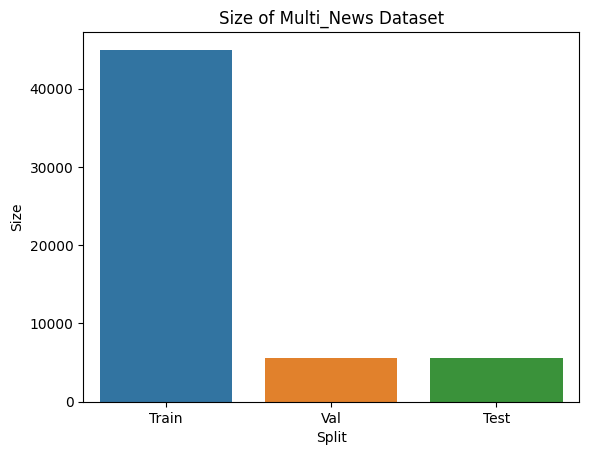

In [15]:
## Checking the size of the dataset
print(f"The sizes are: ({len(multi_train['document'])}, {len(multi_val['document'])}, {len(multi_test['document'])})")

multi_df = {"Split": ["Train", "Val", "Test"],
            "Size": [len(multi_train['document']), len(multi_val['document']), len(multi_test['document'])]}
multi_df = pd.DataFrame.from_dict(multi_df)

sns.barplot(data=multi_df, x="Split", y="Size")
plt.title("Size of Multi_News Dataset")

In [202]:
multi_train['summary'][0]

'– The unemployment rate dropped to 8.2% last month, but the economy only added 120,000 jobs, when 203,000 new jobs had been predicted, according to today\'s jobs report. Reaction on the Wall Street Journal\'s MarketBeat Blog was swift: "Woah!!! Bad number." The unemployment rate, however, is better news; it had been expected to hold steady at 8.3%. But the AP notes that the dip is mostly due to more Americans giving up on seeking employment.'

# 3 Testing Baseline Performance (Multi-news)

## 3.1 Performance on Multi_news Validation Set (without Fine-tuning)

In [179]:
## Helper function to generate results

def generate_abstract_batched(batch_size=1, start=0):
    
    try:
        del val_input_ids, attention_mask, global_attention_mask, predicted_abstract_ids
    except:
        None
        
    gc.collect()

    val_input_ids = val_inputs['input_ids'][start:start+batch_size].to("cuda")
    attention_mask = val_inputs['attention_mask'][start:start+batch_size].to("cuda")

    global_attention_mask = torch.zeros_like(attention_mask)
    global_attention_mask[:, 0] = 1

    predicted_abstract_ids = LEDmodel.generate(val_input_ids,
                                               attention_mask=attention_mask, 
                                               global_attention_mask=global_attention_mask, 
                                               max_length=200, 
                                               num_beams=4)

    predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
    
    return predicted_abstract


In [59]:
## Generating answers
answers = []

for i in range(multi_val.shape[0]):
    if i%500 == 0:
        print(f"Handling sample {i} now..")
        
    answers.append(generate_abstract_batched(start=i))
    
print(f"Completed, {i+1} data points from the {multi_val.shape[0]} validation samples handled.")

Handling sample 0 now..
Handling sample 500 now..
Handling sample 1000 now..
Handling sample 1500 now..
Handling sample 2000 now..
Handling sample 2500 now..
Handling sample 3000 now..
Handling sample 3500 now..
Handling sample 4000 now..
Handling sample 4500 now..
Handling sample 5000 now..
Handling sample 5500 now..
Completed, 5622 data points from the 5622 validation samples handled.


In [80]:
## Calculating the rouge score
rouge.compute(predictions=answers,
              references=multi_val['summary'],
              rouge_types=["rouge1", "rouge2", "rougeL"])

{'rouge1': AggregateScore(low=Score(precision=0.45253162110316586, recall=0.26998620151089253, fmeasure=0.3241583836362227), mid=Score(precision=0.45642679639575445, recall=0.2729729530747623, fmeasure=0.3271969919816484), high=Score(precision=0.46016692175128177, recall=0.275729071344786, fmeasure=0.3299448519888343)),
 'rouge2': AggregateScore(low=Score(precision=0.14000755912845286, recall=0.08202769814712106, fmeasure=0.09892668187304138), mid=Score(precision=0.14275065311251173, recall=0.083671023832943, fmeasure=0.10081800237960234), high=Score(precision=0.1455922502482658, recall=0.08533408180476365, fmeasure=0.10269855845729314)),
 'rougeL': AggregateScore(low=Score(precision=0.24450394039490142, recall=0.1434096150673474, fmeasure=0.1724310740656986), mid=Score(precision=0.24720863688636047, recall=0.14505657121859272, fmeasure=0.17414673745136144), high=Score(precision=0.24996468673278543, recall=0.1468127556953943, fmeasure=0.17601751619539716))}

## 3.2 Testing LED Large Model but with Smaller Seq Len (X-Sci Dataset; Seq Len @1024)

In [209]:
test_inputs_small = LEDtokenizer(xsci_test_processed['abstracts'],
                                 padding="max_length",
                                 max_length=1024,  # maximum sequence length is 16384
                                 return_tensors="pt",
                                 truncation=True)

In [210]:
# Modified version of the code from section 3.1

def generate_abstract_batched3(batch_size=1, start=0):
    
    try:
        del test_input_ids, attention_mask, global_attention_mask, predicted_abstract_ids
    except:
        None
        
    gc.collect()

    test_input_ids = test_inputs_small['input_ids'][start:start+batch_size].to("cuda")
    attention_mask = test_inputs_small['attention_mask'][start:start+batch_size].to("cuda")

    global_attention_mask = torch.zeros_like(attention_mask)
    global_attention_mask[:, 0] = 1

    predicted_abstract_ids = LEDmodel.generate(test_input_ids,
                                               attention_mask=attention_mask, 
                                               global_attention_mask=global_attention_mask, 
                                               max_length=200, 
                                               num_beams=4)

    predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
    
    return predicted_abstract


In [214]:
## Generating answers
answers = []

for i in range(0, xsci_test.num_rows, 2):
    if i%500 == 0:
        print(f"Handling sample {i} now..")
        
    answers.append(generate_abstract_batched3(start=i, batch_size=2))
    
print(f"Completed, {i+1} data points from the {xsci_test.num_rows} X-Sci test samples handled.")

Handling sample 0 now..
Handling sample 500 now..
Handling sample 1000 now..
Handling sample 1500 now..
Handling sample 2000 now..
Handling sample 2500 now..
Handling sample 3000 now..
Handling sample 3500 now..
Handling sample 4000 now..
Handling sample 4500 now..
Handling sample 5000 now..
Completed, 5093 data points from the 5093 X-Sci test samples handled.


In [223]:
formatted_answers = []
for answer in answers:
    formatted_answers += answer
len(formatted_answers)

5093

In [224]:
## Calculating the rouge score
rouge.compute(predictions=formatted_answers,
              references=[ref for ref in xsci_test_processed['related_work']],
              use_stemmer = True)

{'rouge1': AggregateScore(low=Score(precision=0.2828577881531495, recall=0.3542924090709475, fmeasure=0.29791568630342335), mid=Score(precision=0.2857364313099112, recall=0.3570928232785281, fmeasure=0.3001032870535325), high=Score(precision=0.2888360535596914, recall=0.35972154214203655, fmeasure=0.3024218936776045)),
 'rouge2': AggregateScore(low=Score(precision=0.04961522533697241, recall=0.0620449074991023, fmeasure=0.05197015873136566), mid=Score(precision=0.05081806367689046, recall=0.06361816148842929, fmeasure=0.0532626250639876), high=Score(precision=0.05211074689167368, recall=0.06537142864233467, fmeasure=0.05463426591797183)),
 'rougeL': AggregateScore(low=Score(precision=0.14608257812848788, recall=0.18732861173080056, fmeasure=0.15490096187722877), mid=Score(precision=0.14758506336212396, recall=0.18918630483187404, fmeasure=0.1560384691512886), high=Score(precision=0.1492249485523408, recall=0.19119455122798423, fmeasure=0.15732102830261088)),
 'rougeLsum': AggregateScor

## 3.3 Testing LED Base Model with Longer Seq Len (X-Sci Dataset; Seq Len @16384)

In [24]:
## Loading check point

LEDmodel_small = LEDForConditionalGeneration.from_pretrained("allenai/led-base-16384").to("cuda").half()
LEDtokenizer_small = AutoTokenizer.from_pretrained("allenai/led-base-16384")

# LEDtokenizer2 = LEDTokenizer.from_pretrained("allenai/led-large-16384-arxiv")

# LEDmodel = LEDModel.from_pretrained("allenai/led-base-16384")
# LEDtokenizer = LEDTokenizer.from_pretrained("allenai/led-base-16384")

In [25]:
summary(LEDmodel_small)

Layer (type:depth-idx)                             Param #
├─LEDModel: 1-1                                    --
|    └─Embedding: 2-1                              38,603,520
|    └─LEDEncoder: 2-2                             --
|    |    └─Embedding: 3-1                         (recursive)
|    |    └─LEDLearnedPositionalEmbedding: 3-2     12,582,912
|    |    └─ModuleList: 3-3                        53,157,888
|    |    └─LayerNorm: 3-4                         1,536
|    └─LEDDecoder: 2-3                             --
|    |    └─Embedding: 3-5                         (recursive)
|    |    └─LEDLearnedPositionalEmbedding: 3-6     786,432
|    |    └─ModuleList: 3-7                        56,710,656
|    |    └─LayerNorm: 3-8                         1,536
├─Linear: 1-2                                      38,603,520
Total params: 200,448,000
Trainable params: 200,448,000
Non-trainable params: 0


Layer (type:depth-idx)                             Param #
├─LEDModel: 1-1                                    --
|    └─Embedding: 2-1                              38,603,520
|    └─LEDEncoder: 2-2                             --
|    |    └─Embedding: 3-1                         (recursive)
|    |    └─LEDLearnedPositionalEmbedding: 3-2     12,582,912
|    |    └─ModuleList: 3-3                        53,157,888
|    |    └─LayerNorm: 3-4                         1,536
|    └─LEDDecoder: 2-3                             --
|    |    └─Embedding: 3-5                         (recursive)
|    |    └─LEDLearnedPositionalEmbedding: 3-6     786,432
|    |    └─ModuleList: 3-7                        56,710,656
|    |    └─LayerNorm: 3-8                         1,536
├─Linear: 1-2                                      38,603,520
Total params: 200,448,000
Trainable params: 200,448,000
Non-trainable params: 0

In [26]:
test_inputs_base = LEDtokenizer_small(xsci_test_processed['abstracts'],
                                      padding="max_length",
                                      max_length=16384,  # maximum sequence length is 16384
                                      return_tensors="pt",
                                      truncation=True)

In [27]:
# Modified version of the code from section 3.1

def generate_abstract_batched4(batch_size=1, start=0):
    
    try:
        del test_input_ids, attention_mask, global_attention_mask, predicted_abstract_ids
    except:
        None
        
    gc.collect()

    test_input_ids = test_inputs_base['input_ids'][start:start+batch_size].to("cuda")
    attention_mask = test_inputs_base['attention_mask'][start:start+batch_size].to("cuda")

    global_attention_mask = torch.zeros_like(attention_mask)
    global_attention_mask[:, 0] = 1

    predicted_abstract_ids = LEDmodel_small.generate(test_input_ids,
                                                     attention_mask=attention_mask, 
                                                     global_attention_mask=global_attention_mask, 
                                                     max_length=200, 
                                                     num_beams=4)

    predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
    
    return predicted_abstract

In [28]:
## Generating answers
answers = []

for i in range(0, xsci_test.num_rows):
    if i%500 == 0:
        print(f"Handling sample {i} now..")
        
    answers.append(generate_abstract_batched4(start=i, batch_size=1))
    
print(f"Completed, {i+1} data points from the {xsci_test.num_rows} X-Sci test samples handled.")

Handling sample 0 now..
Handling sample 500 now..
Handling sample 1000 now..
Handling sample 1500 now..
Handling sample 2000 now..
Handling sample 2500 now..
Handling sample 3000 now..
Handling sample 3500 now..
Handling sample 4000 now..
Handling sample 4500 now..
Handling sample 5000 now..
Completed, 5093 data points from the 5093 X-Sci test samples handled.


In [29]:
## Calculating the rouge score
rouge.compute(predictions=answers,
              references=[ref for ref in xsci_test_processed['related_work']],
              use_stemmer = True)

{'rouge1': AggregateScore(low=Score(precision=0.2565199901327265, recall=0.39696757791014436, fmeasure=0.29656905171612574), mid=Score(precision=0.25925721057856066, recall=0.39956699771590154, fmeasure=0.2989860911312683), high=Score(precision=0.2619279764408004, recall=0.4020322749067705, fmeasure=0.30113786710119694)),
 'rouge2': AggregateScore(low=Score(precision=0.044353741421259155, recall=0.06898016797175177, fmeasure=0.051331685993534014), mid=Score(precision=0.04524739902170597, recall=0.07026989923436891, fmeasure=0.05232231619959062), high=Score(precision=0.04611685948079741, recall=0.07164729000037254, fmeasure=0.0532435890166319)),
 'rougeL': AggregateScore(low=Score(precision=0.12733245861747325, recall=0.2037458412193547, fmeasure=0.1484822045453607), mid=Score(precision=0.12852239720465752, recall=0.20557580357587146, fmeasure=0.14954117947588846), high=Score(precision=0.12970803335699452, recall=0.20744326367849483, fmeasure=0.15053938683544651)),
 'rougeLsum': Aggrega

## 3.4 Testing LED Base Model with Shorter Seq Len (X-Sci Dataset; Seq Len @1024)

In [43]:
# Modified version of the code from section 3.1

test_inputs_base_short = LEDtokenizer_small(xsci_test_processed['abstracts'],
                                            padding="max_length",
                                            max_length=1024,  # maximum sequence length is 16384
                                            return_tensors="pt",
                                            truncation=True)

def generate_abstract_batched5(batch_size=1, start=0):
    
    try:
        del test_input_ids, attention_mask, global_attention_mask, predicted_abstract_ids
    except:
        None
        
    gc.collect()

    test_input_ids = test_inputs_base_short['input_ids'][start:start+batch_size].to("cuda")
    attention_mask = test_inputs_base_short['attention_mask'][start:start+batch_size].to("cuda")

    global_attention_mask = torch.zeros_like(attention_mask)
    global_attention_mask[:, 0] = 1

    predicted_abstract_ids = LEDmodel_small.generate(test_input_ids,
                                                     attention_mask=attention_mask, 
                                                     global_attention_mask=global_attention_mask, 
                                                     max_length=200, 
                                                     num_beams=4)

    predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
    
    return predicted_abstract

In [45]:
## Generating answers
answers = []

for i in range(0, xsci_test.num_rows, 10):
    if i%500 == 0:
        print(f"Handling sample {i} now..")
        
    answers.append(generate_abstract_batched5(start=i, batch_size=10))
    
print(f"Completed, {i+1} data points from the {xsci_test.num_rows} X-Sci test samples handled.")

Handling sample 0 now..
Handling sample 500 now..
Handling sample 1000 now..
Handling sample 1500 now..
Handling sample 2000 now..
Handling sample 2500 now..
Handling sample 3000 now..
Handling sample 3500 now..
Handling sample 4000 now..
Handling sample 4500 now..
Handling sample 5000 now..
Completed, 5091 data points from the 5093 X-Sci test samples handled.


In [48]:
formatted_answers = []
for answer in answers:
    formatted_answers += answer
len(formatted_answers)

5093

In [49]:
## Calculating the rouge score
rouge.compute(predictions=formatted_answers,
              references=[ref for ref in xsci_test_processed['related_work']],
              use_stemmer = True)

{'rouge1': AggregateScore(low=Score(precision=0.25777805593820435, recall=0.4051098131303811, fmeasure=0.3015415189229105), mid=Score(precision=0.2605307416704722, recall=0.4073830227364882, fmeasure=0.3038425918608533), high=Score(precision=0.2632880270220812, recall=0.40972315953524174, fmeasure=0.30598205781712745)),
 'rouge2': AggregateScore(low=Score(precision=0.04618059572698381, recall=0.0720041936123576, fmeasure=0.05375759475634817), mid=Score(precision=0.04719410556350413, recall=0.07334786071855798, fmeasure=0.05477743227460616), high=Score(precision=0.04815827503150397, recall=0.07472466670500509, fmeasure=0.05573771539763886)),
 'rougeL': AggregateScore(low=Score(precision=0.12721895297634137, recall=0.20764338390824277, fmeasure=0.15055922218080664), mid=Score(precision=0.1284154917132597, recall=0.2092942938774377, fmeasure=0.15160866212191562), high=Score(precision=0.12959589207054714, recall=0.2111048285883659, fmeasure=0.1526563709380539)),
 'rougeLsum': AggregateScor

## 3.5 Comparing the Results from the 4 Experiments
### (i.e. LED Large vs Base; 16384 vs 1024 Seq Len)

In [42]:
## Inputs: abstract of main article plus those of relevant works
xsci_test_processed[0]['abstracts']

"We present our approach to the problem of how an agent, within an economic Multi-Agent System, can determine when it should behave strategically (i.e. learn and use models of other agents), and when it should act as a simple price-taker. We provide a framework for the incremental implementation of modeling capabilities in agents, and a description of the forms of knowledge required. The agents were implemented and different populations simulated in order to learn more about their behavior and the merits of using and learning agent models. Our results show, among other lessons, how savvy buyers can avoid being cheated'' by sellers, how price volatility can be used to quantitatively predict the benefits of deeper models, and how specific types of agent populations influence system behavior.|||||In multi-agent environments, an intelligent agent often needs to interact with other individuals or groups of agents to achieve its goals. Agent tracking is one key capability required for intell

In [40]:
## Label: target summary
xsci_test_processed[0]['related_work']

'Within the MAS community, some work @cite has focused on how artificial AI-based learning agents would fare in communities of similar agents. For example, @cite and @cite show how agents can learn the capabilities of others via repeated interactions, but these agents do not learn to predict what actions other might take. Most of the work in MAS also fails to recognize the possible gains from using explicit agent models to predict agent actions. @cite is an exception and gives another approach for using nested agent models. However, they do not go so far as to try to quantify the advantages of their nested models or show how these could be learned via observations. We believe that our research will bring to the foreground some of the common observations seen in these research areas and help to clarify the implications and utility of learning and using nested agent models.'

In [34]:
## Large LED; 16384 input seq len
answers_run1[0]

[" in multi-agent environments, an intelligent agent often needs to interact with other individuals or groups of agents to achieve its goals. agent tracking is one key capability required for intelligent interaction. \n it involves monitoring the observable actions of other agents and inferring their unobserved actions, plans, goals and behaviors. \n this article examines the implications of such an agent tracking capability for agent architectures. it specifically focuses on real-time and dynamic environments, where an intelligent agent is faced with the challenge of tracking the highly flexible mix of goal-driven and reactive behaviors of other agents, in real-time. \n the key implication is that an agent architecture needs to provide direct support for flexible and efficient reasoning about other agents' models. in this article, such support takes the form of an architectural capability to execute the other agent s models, enabling mental simulation of their behaviors. \n other arch

In [35]:
## Large LED; 1024 input seq len
answers_run2[0]

' we present our approach to the problem of how an agent, within an economic Multi-Agent System, can determine when it should behave strategically (i.e. learn and use models of other agents ), and when it should act as a simple price-taker. we provide a framework for the incremental implementation of modeling capabilities in agents, and a description of the forms of knowledge required. \n we have implemented an agent architecture, an experimental variant of the soar integrated architecture, that conforms to all of these requirements. \n agents based on this architecture have been implemented to execute two different tasks in a real-time, dynamic, multi-agent domain. \n the agents were implemented and different populations simulated in order to learn more about their behavior and the merits of using and learning agent models. \n our results show, among other lessons, how savvy buyers can avoid being cheated by sellers, how price volatility can be used to quantitatively predict the benef

In [36]:
## Base LED; 16384 input seq len
answers_run3[0]

["We present our approach to the problem of how an agent, within an economic Multi-Agent System, can determine when it should behave strategically (i.e. learn and use models of other agents), and when it should act as a simple price-taker. We provide a framework for the incremental implementation of modeling capabilities in agents, and a description of the forms of knowledge required. The agents were implemented and different populations simulated in order to learn more about their behavior and the merits of using and learning agent models. Our results show, among other lessons, how savvy buyers can avoid being cheated'' by sellers, how price volatility can be used to quantitatively predict the benefits of deeper models, and how specific types of agent populations influence system behavior.|||||In multi-agent environments, an intelligent agent often needs to interact with other individuals or groups of agents to achieve its goals. Agent tracking is one key capability required for intel

In [52]:
## Base LED; 1024 input seq len
answers_run4[0]

"We present our approach to the problem of how an agent, within an economic Multi-Agent System, can determine when it should behave strategically (i.e. learn and use models of other agents), and when it should act as a simple price-taker. We provide a framework for the incremental implementation of modeling capabilities in agents, and a description of the forms of knowledge required. The agents were implemented and different populations simulated in order to learn more about their behavior and the merits of using and learning agent models. Our results show, among other lessons, how savvy buyers can avoid being cheated'' by sellers, how price volatility can be used to quantitatively predict the benefits of deeper models, and how specific types of agent populations influence system behavior.|||||In multi-agent environments, an intelligent agent often needs to interact with other individuals or groups of agents to achieve its goals. Agent tracking is one key capability required for intell

# 4 X-Science Dataset

## 4.1 Loading the dataset

In [7]:
## Loading the dataset
xsci_train = load_dataset('multi_x_science_sum', split='train')
xsci_val = load_dataset('multi_x_science_sum', split='validation')
xsci_test = load_dataset('multi_x_science_sum', split='test')

## For text processing as X-Science have not concatenated the source articles
DOC_SEP = "|||||"

Found cached dataset multi_x_science_sum (C:/Users/JustinTo/.cache/huggingface/datasets/multi_x_science_sum/default/1.1.0/2876ec0401f8f5c5acf7f4857dbc8d6229a390ab428321ab848f03f14b7f9729)
Found cached dataset multi_x_science_sum (C:/Users/JustinTo/.cache/huggingface/datasets/multi_x_science_sum/default/1.1.0/2876ec0401f8f5c5acf7f4857dbc8d6229a390ab428321ab848f03f14b7f9729)
Found cached dataset multi_x_science_sum (C:/Users/JustinTo/.cache/huggingface/datasets/multi_x_science_sum/default/1.1.0/2876ec0401f8f5c5acf7f4857dbc8d6229a390ab428321ab848f03f14b7f9729)


## 4.2 Examining the datastructure

In [8]:
## There are 5093 data points for the test set, each with 5 fields:
#  - 'aid': Arxiv id
#  - 'mid': microsoft academic graph id
#  - 'abstract': abstract of the source article.  This is the first input
#  - 'related work': related work section of the soruce article.  This is the reference summary essentially
#  - 'ref_abstract': abstracts of the articles cited and used to write the related work section.  These are the additional inputs
xsci_train, xsci_val, xsci_test

(Dataset({
     features: ['aid', 'mid', 'abstract', 'related_work', 'ref_abstract'],
     num_rows: 30369
 }),
 Dataset({
     features: ['aid', 'mid', 'abstract', 'related_work', 'ref_abstract'],
     num_rows: 5066
 }),
 Dataset({
     features: ['aid', 'mid', 'abstract', 'related_work', 'ref_abstract'],
     num_rows: 5093
 }))

In [9]:
## Sample input
xsci_test[5092]['abstract']

'In this paper we present a novel approach to global localization using an RGB-D camera in maps of visual features. For large maps, the performance of pure image matching techniques decays in terms of robustness and computational cost. Particularly, repeated occurrences of similar features due to repeating structure in the world (e.g., doorways, chairs, etc.) or missing associations between observations pose critical challenges to visual localization. We address these challenges using a two-step approach. We first estimate a candidate pose using few correspondences between features of the current camera frame and the feature map. The initial set of correspondences is established by proximity in feature space. The initial pose estimate is used in the second step to guide spatial matching of features in 3D, i.e., searching for associations where the image features are expected to be found in the map. A RANSAC algorithm is used to compute a fine estimation of the pose from the corresponde

In [10]:
## Sample input (subsequent ones)
## Note that there is one empty article
xsci_test[5092]['ref_abstract']

{'cite_N': ['@cite_18',
  '@cite_4',
  '@cite_22',
  '@cite_28',
  '@cite_27',
  '@cite_2'],
 'mid': ['2111610923',
  '2049981393',
  '',
  '2091226544',
  '2077022309',
  '2127045032'],
 'abstract': ['An RGB-D camera is a sensor which outputs range and color information about objects. Recent technological advances in this area have introduced affordable RGB-D devices in the robotics community. In this paper, we present a real-time technique for 6-DoF camera pose estimation through the incremental registration of RGB-D images. First, a set of edge features are computed from the depth and color images. An initial motion estimation is calculated through aligning the features. This initial guess is refined by applying the Iterative Closest Point algorithm on the dense point cloud data. A rigorous error analysis assesses several sets of RGB-D ground truth data via an error accumulation metric. We show that the proposed two-stage approach significantly reduces error in the pose estimation, 

In [11]:
## Target summary
xsci_test[5092]['related_work']

'To the best of our knowledge, at the time being, there is no other dedicated global localization approach for the recently introduced RGB-D sensors. However, a number of novel approaches for visual odometry have been proposed, which exploit the available combination of color, density of depth and the high frame rate to improve alignment performance as compared, e.g., to the iterative closest point algorithm @cite_4 . In @cite_18 and @cite_2 adaptations of ICP are proposed to process the high amounts of data more efficiently. Steinbruecker @cite_28 present a transformation estimation based on the minimization of an energy function. For frames close to each other, they achieve enhanced runtime performance and accuracy compared to Generalized ICP @cite_22 . Using the distribution of normals, Osteen @cite_27 improve the initialization of ICP by efficiently computing the difference in orientation between two frames, which allows a substantial drift reduction. These approaches work well for

## 4.3 Preprocessing before tokenization

In [12]:
pat = re.compile("@cite_[0-9]+")

In [13]:
def preprocess_dataset(example):
    output = {}
    output["abstracts"] = (
        example["abstract"].split("| Abstract: ")[-1]
        + DOC_SEP
        + DOC_SEP.join([x for x in example["ref_abstract"]["abstract"] if x])
    )
    output["related_work"] = pat.sub("@cite", example["related_work"])
    
    return output

In [14]:
def preprocess_dataset_batched(example):
    output = {}
    output["abstracts"] = []
    output["related_work"] = []
    
    for abstract, ref_abstract in zip(
        example["abstract"], example["ref_abstract"]
    ):
        output["abstracts"].append(
            abstract.split("| Abstract: ")[-1]
            + DOC_SEP
            + DOC_SEP.join([x for x in ref_abstract["abstract"] if x])
        )
    for related_work in example["related_work"]:
        output["related_work"].append(pat.sub("@cite", related_work))
    
    return output

In [15]:
xsci_train_processed = xsci_train.map(
    # preprocess_dataset,
    preprocess_dataset_batched,
    remove_columns=xsci_test.column_names,
    batched=True,
    batch_size=1,
    )

xsci_val_processed = xsci_val.map(
    # preprocess_dataset,
    preprocess_dataset_batched,
    remove_columns=xsci_test.column_names,
    batched=True,
    batch_size=1,
    )

xsci_test_processed = xsci_test.map(
    # preprocess_dataset,
    preprocess_dataset_batched,
    remove_columns=xsci_test.column_names,
    batched=True,
    batch_size=1,
    )

Parameter 'function'=<function preprocess_dataset_batched at 0x000001B56E013040> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/30369 [00:00<?, ?ba/s]

  0%|          | 0/5066 [00:00<?, ?ba/s]

  0%|          | 0/5093 [00:00<?, ?ba/s]

In [16]:
xsci_train_processed, xsci_val_processed, xsci_test_processed

(Dataset({
     features: ['related_work', 'abstracts'],
     num_rows: 30369
 }),
 Dataset({
     features: ['related_work', 'abstracts'],
     num_rows: 5066
 }),
 Dataset({
     features: ['related_work', 'abstracts'],
     num_rows: 5093
 }))

In [17]:
## Post processing inputs
xsci_test_processed[5092]['abstracts']

"In this paper we present a novel approach to global localization using an RGB-D camera in maps of visual features. For large maps, the performance of pure image matching techniques decays in terms of robustness and computational cost. Particularly, repeated occurrences of similar features due to repeating structure in the world (e.g., doorways, chairs, etc.) or missing associations between observations pose critical challenges to visual localization. We address these challenges using a two-step approach. We first estimate a candidate pose using few correspondences between features of the current camera frame and the feature map. The initial set of correspondences is established by proximity in feature space. The initial pose estimate is used in the second step to guide spatial matching of features in 3D, i.e., searching for associations where the image features are expected to be found in the map. A RANSAC algorithm is used to compute a fine estimation of the pose from the corresponde

In [18]:
## Citation numbers changed to just "@cite" following the X-Sci dataset paper (vide sectiom 3.2)
xsci_test_processed[5092]['related_work']

'To the best of our knowledge, at the time being, there is no other dedicated global localization approach for the recently introduced RGB-D sensors. However, a number of novel approaches for visual odometry have been proposed, which exploit the available combination of color, density of depth and the high frame rate to improve alignment performance as compared, e.g., to the iterative closest point algorithm @cite . In @cite and @cite adaptations of ICP are proposed to process the high amounts of data more efficiently. Steinbruecker @cite present a transformation estimation based on the minimization of an energy function. For frames close to each other, they achieve enhanced runtime performance and accuracy compared to Generalized ICP @cite . Using the distribution of normals, Osteen @cite improve the initialization of ICP by efficiently computing the difference in orientation between two frames, which allows a substantial drift reduction. These approaches work well for computing the t

## 4.4 Tokenization

In [19]:
## Tokenizing using LED Tokenizer (essentially the same as PRIMERA)
## Used for EDA and also subsequent model fitting

# train_inputs = LEDtokenizer(xsci_train_processed['abstracts'],
#                             padding="max_length",
#                             max_length=16384,  # maximum sequence length is 16384
#                             return_tensors="pt",
#                             truncation=True)

# val_inputs = LEDtokenizer(xsci_val_processed['abstracts'],
#                           padding="max_length",
#                           max_length=16384,  # maximum sequence length is 16384
#                           return_tensors="pt",
#                           truncation=True)

test_inputs = LEDtokenizer(xsci_test_processed['abstracts'],
                           padding="max_length",
                           max_length=16384,  # maximum sequence length is 16384
                           return_tensors="pt",
                           truncation=True)

In [20]:
(test_inputs['input_ids'].shape, test_inputs['attention_mask'].shape)

(torch.Size([5093, 16384]), torch.Size([5093, 16384]))

In [21]:
# train_labels = LEDtokenizer(xsci_train_processed['related_work'],
#                             padding=True,
#                             return_tensors="pt")

# val_labels = LEDtokenizer(xsci_val_processed['related_work'],
#                           padding=True,
#                           return_tensors="pt")

test_labels = LEDtokenizer(xsci_test_processed['related_work'],
                           padding=True,
                           return_tensors="pt")

In [22]:
(test_labels['input_ids'].shape, test_labels['attention_mask'].shape)

(torch.Size([5093, 418]), torch.Size([5093, 418]))

In [23]:
xsci_test_processed['abstracts'][0]

"We present our approach to the problem of how an agent, within an economic Multi-Agent System, can determine when it should behave strategically (i.e. learn and use models of other agents), and when it should act as a simple price-taker. We provide a framework for the incremental implementation of modeling capabilities in agents, and a description of the forms of knowledge required. The agents were implemented and different populations simulated in order to learn more about their behavior and the merits of using and learning agent models. Our results show, among other lessons, how savvy buyers can avoid being cheated'' by sellers, how price volatility can be used to quantitatively predict the benefits of deeper models, and how specific types of agent populations influence system behavior.|||||In multi-agent environments, an intelligent agent often needs to interact with other individuals or groups of agents to achieve its goals. Agent tracking is one key capability required for intell

## 4.5 EDAs on the X-Science Dataset (Part 1)

In [142]:
## Estimating the token length of the train data set
len_tr_inputs = []
len_tr_labels = []
for idx, sample in enumerate(xsci_train_processed['abstracts']):
    try:
        temp = LEDtokenizer(sample, return_tensors="pt")
        len_tr_inputs.append(temp.input_ids.shape[1])
    except:
        try:
            print(f"sample {idx} entering inner loop.")
            sample_1, sample_2 = sample[:len(sample//2)], sample[len(sample//2):]
            len_tr_inputs.append(LEDtokenizer(sample_1, return_tensors="pt")
                                + LEDtokenizer(sample_2, return_tensors="pt") 
                                - 2)
        except:
            print(f"sample {idx} has more than double the length of 16384!")
            
for idx, sample in enumerate(xsci_train_processed['related_work']):
    try:
        temp = LEDtokenizer(sample, return_tensors="pt")
        len_tr_labels.append(temp.input_ids.shape[1])
    except:
        try:
            print(f"sample {idx} entering inner loop.")
            sample_1, sample_2 = sample[:len(sample//2)], sample[len(sample//2):]
            len_tr_labels.append(LEDtokenizer(sample_1, return_tensors="pt")
                                + LEDtokenizer(sample_2, return_tensors="pt") 
                                - 2)
        except:
            print(f"sample {idx} has more than double the length of 16384!")

In [26]:
## Estimating the token length of the validation data set
len_v_inputs = []
len_v_labels = []
for idx, sample in enumerate(xsci_val_processed['abstracts']):
    try:
        temp = LEDtokenizer(sample, return_tensors="pt")
        len_v_inputs.append(temp.input_ids.shape[1])
    except:
        try:
            print(f"sample {idx} entering inner loop.")
            sample_1, sample_2 = sample[:len(sample//2)], sample[len(sample//2):]
            len_v_inputs.append(LEDtokenizer(sample_1, return_tensors="pt")
                                + LEDtokenizer(sample_2, return_tensors="pt") 
                                - 2)
        except:
            print(f"sample {idx} has more than double the length of 16384!")
            
for idx, sample in enumerate(xsci_val_processed['related_work']):
    try:
        temp = LEDtokenizer(sample, return_tensors="pt")
        len_v_labels.append(temp.input_ids.shape[1])
    except:
        try:
            print(f"sample {idx} entering inner loop.")
            sample_1, sample_2 = sample[:len(sample//2)], sample[len(sample//2):]
            len_v_labels.append(LEDtokenizer(sample_1, return_tensors="pt")
                                + LEDtokenizer(sample_2, return_tensors="pt") 
                                - 2)
        except:
            print(f"sample {idx} has more than double the length of 16384!")

In [105]:
## Estimating the token length of the test data set
len_t_inputs = []
len_t_labels = []
for idx, sample in enumerate(xsci_test_processed['abstracts']):
    try:
        temp = LEDtokenizer(sample, return_tensors="pt")
        len_t_inputs.append(temp.input_ids.shape[1])
    except:
        try:
            print(f"sample {idx} entering inner loop.")
            sample_1, sample_2 = sample[:len(sample//2)], sample[len(sample//2):]
            len_t_inputs.append(LEDtokenizer(sample_1, return_tensors="pt")
                                + LEDtokenizer(sample_2, return_tensors="pt") 
                                - 2)
        except:
            print(f"sample {idx} has more than double the length of 16384!")
            
for idx, sample in enumerate(xsci_test_processed['related_work']):
    try:
        temp = LEDtokenizer(sample, return_tensors="pt")
        len_t_labels.append(temp.input_ids.shape[1])
    except:
        try:
            print(f"sample {idx} entering inner loop.")
            sample_1, sample_2 = sample[:len(sample//2)], sample[len(sample//2):]
            len_t_labels.append(LEDtokenizer(sample_1, return_tensors="pt")
                                + LEDtokenizer(sample_2, return_tensors="pt") 
                                - 2)
        except:
            print(f"sample {idx} has more than double the length of 16384!")

In [28]:
## Checking the results:
print("-----Results for Train Inputs-----")
print(f"1. The number of samples evaluated in the test set is: {len(len_tr_inputs)}")
print(f"2. The max sequence length, using the LED tokenizer, is: {max(len_tr_inputs)}, at location {len_tr_inputs.index(max(len_tr_inputs))}.")
print(f"3. The min sequence length, using the LED tokenizer, is: {min(len_tr_inputs)}, at location {len_tr_inputs.index(min(len_tr_inputs))}.")
print(f"4. The mean and std for sequence length, using the LED tokenizer, are: {np.mean(len_tr_inputs):.2f} and {np.std(len_tr_inputs):.2f}.")
print(f"5. The number of samples exceeding 1024 token length is: {np.array(len_tr_inputs)[np.array(len_tr_inputs) > 1024].shape[0]}"
     + f", which is {100*np.array(len_tr_inputs)[np.array(len_tr_inputs) > 1024].shape[0]/len(len_tr_inputs):.2f}% of the samples.")

print("\n-----Results for Train Labels-----")
print(f"1. The number of samples evaluated in the test set is: {len(len_tr_labels)}")
print(f"2. The max sequence length, using the LED tokenizer, is: {max(len_tr_labels)}, at location {len_tr_labels.index(max(len_tr_labels))}.")
print(f"3. The min sequence length, using the LED tokenizer, is: {min(len_tr_labels)}, at location {len_tr_labels.index(min(len_tr_labels))}.")
print(f"4. The mean and std for sequence length, using the LED tokenizer, are: {np.mean(len_tr_labels):.2f} and {np.std(len_tr_labels):.2f}.")
print(f"5. The number of samples exceeding 1024 token length is: {np.array(len_tr_labels)[np.array(len_tr_labels) > 1024].shape[0]}"
     + f", which is {100*np.array(len_tr_labels)[np.array(len_tr_labels) > 1024].shape[0]/len(len_tr_labels):.2f}% of the samples.")

print("\n-----Results for Validation Inputs-----")
print(f"1. The number of samples evaluated in the test set is: {len(len_v_inputs)}")
print(f"2. The max sequence length, using the LED tokenizer, is: {max(len_v_inputs)}, at location {len_v_inputs.index(max(len_v_inputs))}.")
print(f"3. The min sequence length, using the LED tokenizer, is: {min(len_v_inputs)}, at location {len_v_inputs.index(min(len_v_inputs))}.")
print(f"4. The mean and std for sequence length, using the LED tokenizer, are: {np.mean(len_v_inputs):.2f} and {np.std(len_v_inputs):.2f}.")
print(f"5. The number of samples exceeding 1024 token length is: {np.array(len_v_inputs)[np.array(len_v_inputs) > 1024].shape[0]}"
     + f", which is {100*np.array(len_v_inputs)[np.array(len_v_inputs) > 1024].shape[0]/len(len_v_inputs):.2f}% of the samples.")

print("\n-----Results for Validation Labels-----")
print(f"1. The number of samples evaluated in the test set is: {len(len_v_labels)}")
print(f"2. The max sequence length, using the LED tokenizer, is: {max(len_v_labels)}, at location {len_v_labels.index(max(len_v_labels))}.")
print(f"3. The min sequence length, using the LED tokenizer, is: {min(len_v_labels)}, at location {len_v_labels.index(min(len_v_labels))}.")
print(f"4. The mean and std for sequence length, using the LED tokenizer, are: {np.mean(len_v_labels):.2f} and {np.std(len_v_labels):.2f}.")
print(f"5. The number of samples exceeding 1024 token length is: {np.array(len_v_labels)[np.array(len_v_labels) > 1024].shape[0]}"
     + f", which is {100*np.array(len_v_labels)[np.array(len_v_labels) > 1024].shape[0]/len(len_v_labels):.2f}% of the samples.")

print("\n-----Results for Test Inputs-----")
print(f"1. The number of samples evaluated in the test set is: {len(len_t_inputs)}")
print(f"2. The max sequence length, using the LED tokenizer, is: {max(len_t_inputs)}, at location {len_t_inputs.index(max(len_t_inputs))}.")
print(f"3. The min sequence length, using the LED tokenizer, is: {min(len_t_inputs)}, at location {len_t_inputs.index(min(len_t_inputs))}.")
print(f"4. The mean and std for sequence length, using the LED tokenizer, are: {np.mean(len_t_inputs):.2f} and {np.std(len_t_inputs):.2f}.")
print(f"5. The number of samples exceeding 1024 token length is: {np.array(len_t_inputs)[np.array(len_t_inputs) > 1024].shape[0]}"
     + f", which is {100*np.array(len_t_inputs)[np.array(len_t_inputs) > 1024].shape[0]/len(len_t_inputs):.2f}% of the samples.")

print("\n-----Results for Test Labels-----")
print(f"1. The number of samples evaluated in the test set is: {len(len_t_labels)}")
print(f"2. The max sequence length, using the LED tokenizer, is: {max(len_t_labels)}, at location {len_t_labels.index(max(len_t_labels))}.")
print(f"3. The min sequence length, using the LED tokenizer, is: {min(len_t_labels)}, at location {len_t_labels.index(min(len_t_labels))}.")
print(f"4. The mean and std for sequence length, using the LED tokenizer, are: {np.mean(len_t_labels):.2f} and {np.std(len_t_labels):.2f}.")
print(f"5. The number of samples exceeding 1024 token length is: {np.array(len_t_labels)[np.array(len_t_labels) > 1024].shape[0]}"
     + f", which is {100*np.array(len_t_labels)[np.array(len_t_labels) > 1024].shape[0]/len(len_t_labels):.2f}% of the samples.")

-----Results for Train Inputs-----
1. The number of samples evaluated in the test set is: 30369
2. The max sequence length, using the LED tokenizer, is: 4694, at location 26192.
3. The min sequence length, using the LED tokenizer, is: 82, at location 967.
4. The mean and std for sequence length, using the LED tokenizer, are: 898.83 and 565.03.
5. The number of samples exceeding 1024 token length is: 9478, which is 31.21% of the samples.

-----Results for Train Labels-----
1. The number of samples evaluated in the test set is: 30369
2. The max sequence length, using the LED tokenizer, is: 735, at location 5414.
3. The min sequence length, using the LED tokenizer, is: 24, at location 17798.
4. The mean and std for sequence length, using the LED tokenizer, are: 142.15 and 58.20.
5. The number of samples exceeding 1024 token length is: 0, which is 0.00% of the samples.

-----Results for Validation Inputs-----
1. The number of samples evaluated in the test set is: 5066
2. The max sequence l

## 4.6 Some Interesting Samples (shows the dataset may benefit from some clearning?)

In [31]:
# Summary of shortest length (24!!) in the traininhg set
xsci_train_processed[17798]['related_work']

'For additional information about architectures, algorithms, and applications of deep learning, please refer the survey @cite .'

In [32]:
# Summary of shortest length (25!!) in the traininhg set
xsci_val_processed[1407]['related_work']

'A good overview of transfer learning research and terminology can be found at: @cite , we follow this terminology.'

In [33]:
# Summary of shortest length (26!!) in the traininhg set
xsci_test_processed[1167]['related_work']

'Recent surveys @cite , @cite , @cite may provide additional background on domain adaptation and transfer learning.'

## 4.7 EDAs on the X-Science Dataset (Part 2)

In [102]:
## Statistics at source article level

len_tr_sources = []
len_v_sources = []
len_t_sources = []

for idx, (abstract, references) in enumerate(zip(xsci_train['abstract'], xsci_train['ref_abstract'])):
    
    abs_len = LEDtokenizer(abstract, return_tensors="pt").input_ids.shape[1]
    ref_lens = [LEDtokenizer(reference, return_tensors="pt").input_ids.shape[1] for reference in references['abstract'] if len(reference)>0]
    
    len_tr_sources.append(tuple([abs_len]+ref_lens))
    
for idx, (abstract, references) in enumerate(zip(xsci_val['abstract'], xsci_val['ref_abstract'])):
    
    abs_len = LEDtokenizer(abstract, return_tensors="pt").input_ids.shape[1]
    ref_lens = [LEDtokenizer(reference, return_tensors="pt").input_ids.shape[1] for reference in references['abstract'] if len(reference)>0]
    
    len_v_sources.append(tuple([abs_len]+ref_lens))    

for idx, (abstract, references) in enumerate(zip(xsci_test['abstract'], xsci_test['ref_abstract'])):
    
    abs_len = LEDtokenizer(abstract, return_tensors="pt").input_ids.shape[1]
    ref_lens = [LEDtokenizer(reference, return_tensors="pt").input_ids.shape[1] for reference in references['abstract'] if len(reference)>0]
    
    len_t_sources.append(tuple([abs_len]+ref_lens))

-----Results for Training Set (by Source Article)-----
1. Mean and std of the abstract of the main article: 215.18, 65.89.
2. Mean and std of the abstract of the reference articles: 199.48, 72.02.
3. Mean and std of all abstracts combined: 203.03, 70.98.
4. Mean and std of the number of abstracts per sample: 4.43, 2.62.
5. Max number of abstracts per sample: 21, at location 2942
6. Min number of abstracts per sample: 2, at location 1
7. Most common number of abstracts per sample: 2, occuring in 7814 samples.



Text(0, 0.5, 'Total Token Length')

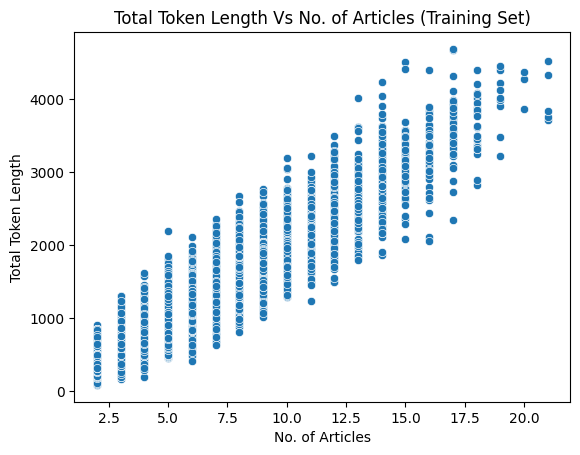

In [155]:
## Stat for Training Set
ref_articles_tr = []
all_articles_tr = []
for l in [list(articles[1:]) for articles in len_tr_sources]:
    ref_articles_tr += l
for l in [list(articles) for articles in len_tr_sources]:
    all_articles_tr += l 

print("-----Results for Training Set (by Source Article)-----")
print(f"1. Mean and std of the abstract of the main article: {np.mean([articles[0] for articles in len_tr_sources]):.2f}"
     + f", {np.std([articles[0] for articles in len_tr_sources]):.2f}.")
print(f"2. Mean and std of the abstract of the reference articles: {np.mean(ref_articles_tr):.2f}"
     + f", {np.std(ref_articles_tr):.2f}.")
print(f"3. Mean and std of all abstracts combined: {np.mean(all_articles_tr):.2f}"
     + f", {np.std(all_articles_tr):.2f}.")
print(f"4. Mean and std of the number of abstracts per sample: {np.mean([len(ref) for ref in len_tr_sources]):.2f}"
     + f", {np.std([len(ref) for ref in len_tr_sources]):.2f}.")
print(f"5. Max number of abstracts per sample: {max([len(ref) for ref in len_tr_sources])}, at location {[len(ref) for ref in len_tr_sources].index(max([len(ref) for ref in len_tr_sources]))}")
print(f"6. Min number of abstracts per sample: {min([len(ref) for ref in len_tr_sources])}, at location {[len(ref) for ref in len_tr_sources].index(min([len(ref) for ref in len_tr_sources]))}")
print(f"7. Most common number of abstracts per sample: {st.mode([len(ref) for ref in len_tr_sources]).mode[0]}, occuring in {st.mode([len(ref) for ref in len_tr_sources]).count[0]} samples.\n")

sns.scatterplot(x=[len(ref) for ref in len_tr_sources],
                y=len_tr_inputs)
plt.title("Total Token Length Vs No. of Articles (Training Set)")
plt.xlabel("No. of Articles")
plt.ylabel("Total Token Length")

Text(0, 0.5, 'Total Token Length')

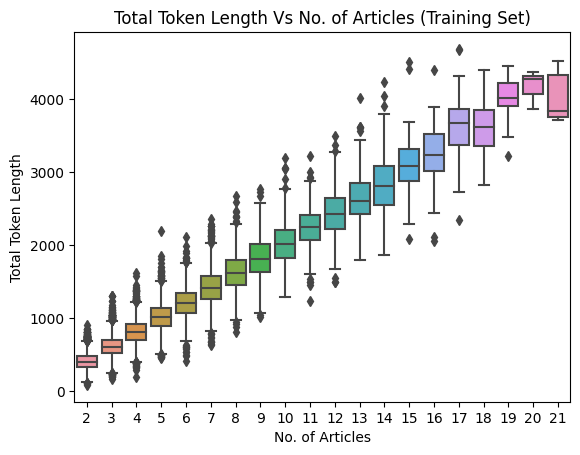

In [176]:
## Boxplot for Tarining Set
sns.boxplot(x=[len(ref) for ref in len_tr_sources],
            y=len_tr_inputs)
plt.title("Total Token Length Vs No. of Articles (Training Set)")
plt.xlabel("No. of Articles")
plt.ylabel("Total Token Length")

-----Results for Validation Set (by Source Article)-----
1. Mean and std of the abstract of the main article: 213.59, 65.91.
2. Mean and std of the abstract of the reference articles: 199.55, 72.47.
3. Mean and std of all abstracts combined: 202.72, 71.28.
4. Mean and std of the number of abstracts per sample: 4.43, 2.63.
5. Max number of abstracts per sample: 20, at location 2172
6. Min number of abstracts per sample: 2, at location 0
7. Most common number of abstracts per sample: 2, occuring in 1293 samples.



Text(0, 0.5, 'Total Token Length')

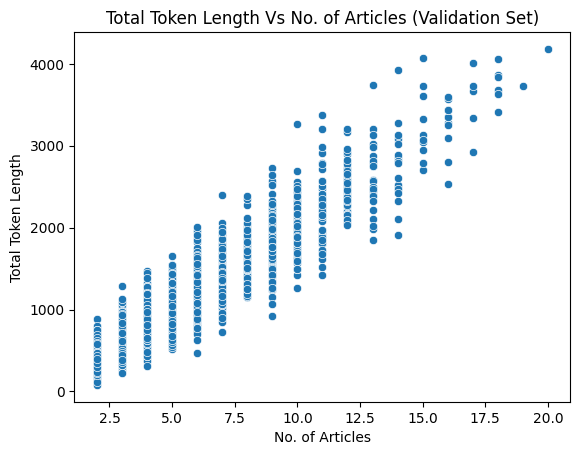

In [169]:
## Stat for Validation Set
ref_articles_v = []
all_articles_v = []
for l in [list(articles[1:]) for articles in len_v_sources]:
    ref_articles_v += l
for l in [list(articles) for articles in len_v_sources]:
    all_articles_v += l 

print("-----Results for Validation Set (by Source Article)-----")
print(f"1. Mean and std of the abstract of the main article: {np.mean([articles[0] for articles in len_v_sources]):.2f}"
     + f", {np.std([articles[0] for articles in len_v_sources]):.2f}.")
print(f"2. Mean and std of the abstract of the reference articles: {np.mean(ref_articles_v):.2f}"
     + f", {np.std(ref_articles_v):.2f}.")
print(f"3. Mean and std of all abstracts combined: {np.mean(all_articles_v):.2f}"
     + f", {np.std(all_articles_v):.2f}.")
print(f"4. Mean and std of the number of abstracts per sample: {np.mean([len(ref) for ref in len_v_sources]):.2f}"
     + f", {np.std([len(ref) for ref in len_v_sources]):.2f}.")
print(f"5. Max number of abstracts per sample: {max([len(ref) for ref in len_v_sources])}, at location {[len(ref) for ref in len_v_sources].index(max([len(ref) for ref in len_v_sources]))}")
print(f"6. Min number of abstracts per sample: {min([len(ref) for ref in len_v_sources])}, at location {[len(ref) for ref in len_v_sources].index(min([len(ref) for ref in len_v_sources]))}")
print(f"7. Most common number of abstracts per sample: {st.mode([len(ref) for ref in len_v_sources]).mode[0]}, occuring in {st.mode([len(ref) for ref in len_v_sources]).count[0]} samples.\n")

sns.scatterplot(x=[len(ref) for ref in len_v_sources],
                y=len_v_inputs)
plt.title("Total Token Length Vs No. of Articles (Validation Set)")
plt.xlabel("No. of Articles")
plt.ylabel("Total Token Length")

Text(0, 0.5, 'Total Token Length')

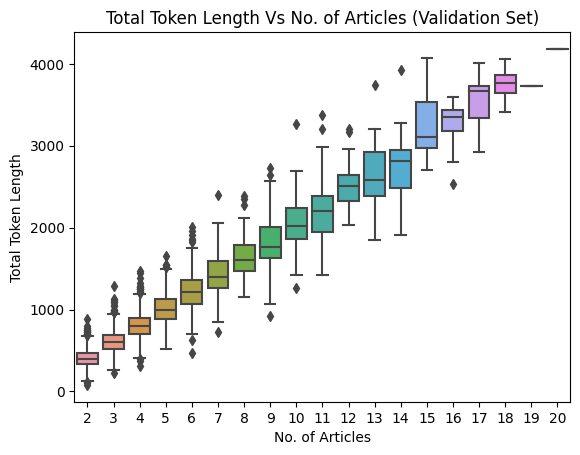

In [174]:
## Boxplot for Validation Set
sns.boxplot(x=[len(ref) for ref in len_v_sources],
            y=len_v_inputs)
plt.title("Total Token Length Vs No. of Articles (Validation Set)")
plt.xlabel("No. of Articles")
plt.ylabel("Total Token Length")

-----Results for Test Set (by Source Article)-----
1. Mean and std of the abstract of the main article: 213.96, 68.09.
2. Mean and std of the abstract of the reference articles: 198.21, 74.32.
3. Mean and std of all abstracts combined: 201.80, 73.24.
4. Mean and std of the number of abstracts per sample: 4.39, 2.55.
5. Max number of abstracts per sample: 19, at location 3300
6. Min number of abstracts per sample: 2, at location 1
7. Most common number of abstracts per sample: 2, occuring in 1308 samples.



Text(0, 0.5, 'Total Token Length')

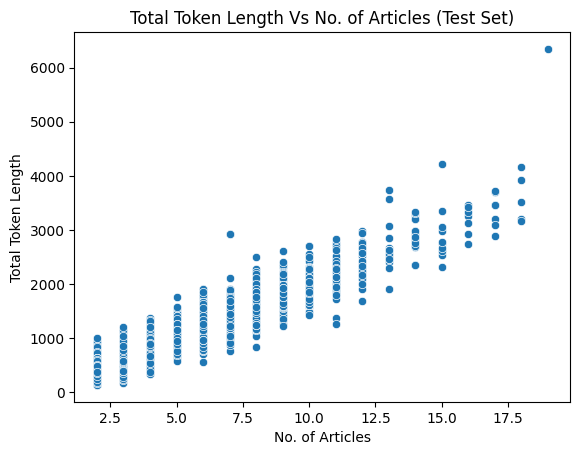

In [106]:
## Stat for Test Set
ref_articles_t = []
all_articles_t = []
for l in [list(articles[1:]) for articles in len_t_sources]:
    ref_articles_t += l
for l in [list(articles) for articles in len_t_sources]:
    all_articles_t += l 

print("-----Results for Test Set (by Source Article)-----")
print(f"1. Mean and std of the abstract of the main article: {np.mean([articles[0] for articles in len_t_sources]):.2f}"
     + f", {np.std([articles[0] for articles in len_t_sources]):.2f}.")
print(f"2. Mean and std of the abstract of the reference articles: {np.mean(ref_articles_t):.2f}"
     + f", {np.std(ref_articles_t):.2f}.")
print(f"3. Mean and std of all abstracts combined: {np.mean(all_articles_t):.2f}"
     + f", {np.std(all_articles_t):.2f}.")
print(f"4. Mean and std of the number of abstracts per sample: {np.mean([len(ref) for ref in len_t_sources]):.2f}"
     + f", {np.std([len(ref) for ref in len_t_sources]):.2f}.")
print(f"5. Max number of abstracts per sample: {max([len(ref) for ref in len_t_sources])}, at location {[len(ref) for ref in len_t_sources].index(max([len(ref) for ref in len_t_sources]))}")
print(f"6. Min number of abstracts per sample: {min([len(ref) for ref in len_t_sources])}, at location {[len(ref) for ref in len_t_sources].index(min([len(ref) for ref in len_t_sources]))}")
print(f"7. Most common number of abstracts per sample: {st.mode([len(ref) for ref in len_t_sources]).mode[0]}, occuring in {st.mode([len(ref) for ref in len_t_sources]).count[0]} samples.\n")

sns.scatterplot(x=[len(ref) for ref in len_t_sources],
                y=len_t_inputs)
plt.title("Total Token Length Vs No. of Articles (Test Set)")
plt.xlabel("No. of Articles")
plt.ylabel("Total Token Length")

Text(0, 0.5, 'Total Token Length')

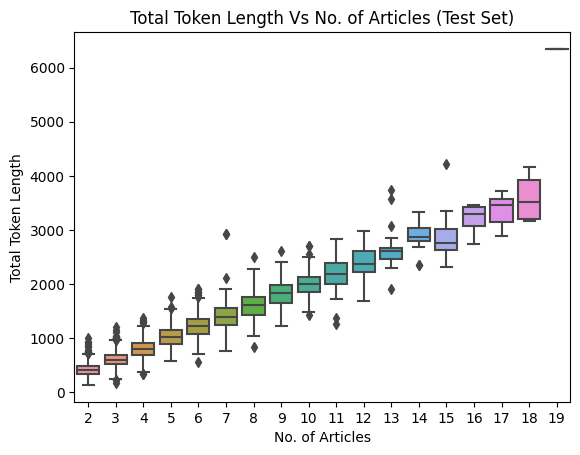

In [178]:
## Boxplot for Tarining Set
sns.boxplot(x=[len(ref) for ref in len_t_sources],
            y=len_t_inputs)
plt.title("Total Token Length Vs No. of Articles (Test Set)")
plt.xlabel("No. of Articles")
plt.ylabel("Total Token Length")

## 4.8 Another Batch of Interesting Samples (Samples with V Large No of Refernces)

In [162]:
## There are 20 references!
xsci_train[2942]['ref_abstract']['abstract']

['Data-driven algorithms have surpassed traditional techniques in almost every aspect in robotic vision problems. Such algorithms need vast amounts of quality data to be able to work properly after their training process. Gathering and annotating that sheer amount of data in the real world is a time-consuming and error-prone task. Those problems limit scale and quality. Synthetic data generation has become increasingly popular since it is faster to generate and automatic to annotate. However, most of the current datasets and environments lack realism, interactions, and details from the real world. UnrealROX is an environment built over Unreal Engine 4 which aims to reduce that reality gap by leveraging hyperrealistic indoor scenes that are explored by robot agents which also interact with objects in a visually realistic manner in that simulated world. Photorealistic scenes and robots are rendered by Unreal Engine into a virtual reality headset which captures gaze so that a human operat

In [163]:
## There are 20 references!
xsci_val[2172]['ref_abstract']['abstract']

['The goal of this paper is to generate high-quality 3D object proposals in the context of autonomous driving. Our method exploits stereo imagery to place proposals in the form of 3D bounding boxes. We formulate the problem as minimizing an energy function encoding object size priors, ground plane as well as several depth informed features that reason about free space, point cloud densities and distance to the ground. Our experiments show significant performance gains over existing RGB and RGB-D object proposal methods on the challenging KITTI benchmark. Combined with convolutional neural net (CNN) scoring, our approach outperforms all existing results on all three KITTI object classes.',
 'The depth information of RGB-D sensors has greatly simplified some common challenges in computer vision and enabled breakthroughs for several tasks. In this paper, we propose to use depth maps for object detection and design a 3D detector to overcome the major difficulties for recognition, namely th

In [53]:
## There are 19 references!
xsci_test[3300]['ref_abstract']['abstract']

['A spanner of an undirected unweighted graph is a subgraph that approximates the distance metric of the original graph with some specified accuracy. Specifically, we say H ⊆ G is an f-spanner of G if any two vertices u,v at distance d in G are at distance at most f(d) in H. There is clearly some trade-off between the sparsity of H and the distortion function f, though the nature of the optimal trade-off is still poorly understood. In this article we present a simple, modular framework for constructing sparse spanners that is based on interchangable components called connection schemes. By assembling connection schemes in different ways we can recreate the additive 2- and 6-spanners of [1999] and [2009], and give spanners whose multiplicative distortion quickly tends toward 1. Our results rival the simplicity of all previous algorithms and provide substantial improvements (up to a doubly exponential reduction in edge density) over the comparable spanners of Elkin and Peleg [2004] and T

## 4.9 EDA Part 3 - on Target Labels

In [58]:
len_tr_labels = []
len_v_labels = []
len_t_labels = []

for reference in xsci_train['related_work']:
    
    len_tr_labels.append(LEDtokenizer(reference, return_tensors="pt").input_ids.shape[1])
    
for reference in xsci_val_processed['related_work']:
    
    len_v_labels.append(LEDtokenizer(reference, return_tensors="pt").input_ids.shape[1])
    
for reference in xsci_test_processed['related_work']:
    
    len_t_labels.append(LEDtokenizer(reference, return_tensors="pt").input_ids.shape[1])

-----Results for Training Set Labels-----
1. Mean and std of the target reference (i.e. related work): 151.12, 62.24.
2. Max number of tokens in target reference: 753, at location 5414
3. Min number of tokens in target reference: 26, at location 17798

-----Results for Validation Set Labels-----
1. Mean and std of the target reference (i.e. related work): 140.52, 57.74.
2. Max number of tokens in target reference: 324, at location 2435
3. Min number of tokens in target reference: 25, at location 1407

-----Results for Test Set Labels-----
1. Mean and std of the target reference (i.e. related work): 141.86, 58.18.
2. Max number of tokens in target reference: 418, at location 4155
3. Min number of tokens in target reference: 26, at location 1167


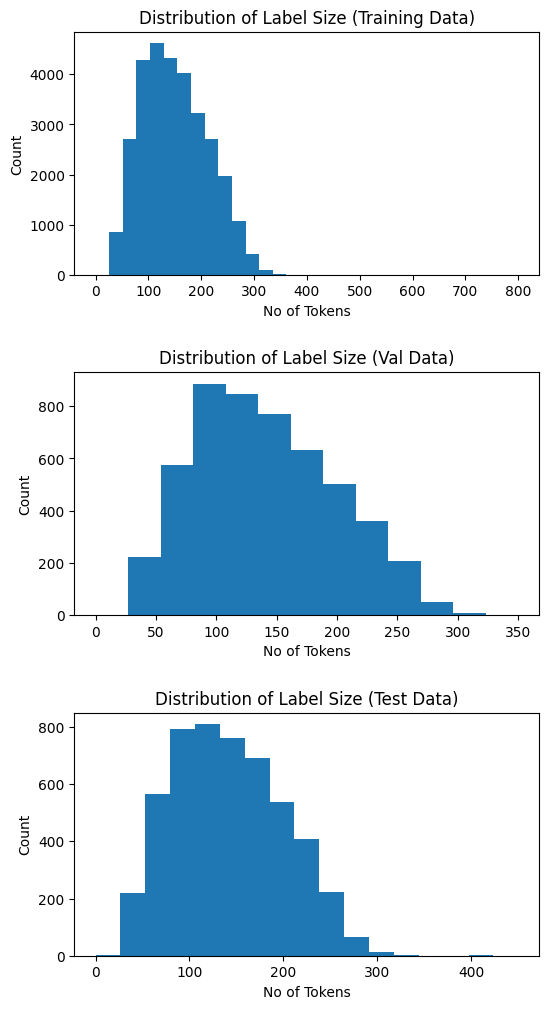

In [101]:
## Stats and plots

print("-----Results for Training Set Labels-----")
print(f"1. Mean and std of the target reference (i.e. related work): {np.mean(len_tr_labels):.2f}"
     + f", {np.std(len_tr_labels):.2f}.")
print(f"2. Max number of tokens in target reference: {max(len_tr_labels)}, at location {len_tr_labels.index(max(len_tr_labels))}")
print(f"3. Min number of tokens in target reference: {min(len_tr_labels)}, at location {len_tr_labels.index(min(len_tr_labels))}")

print("\n-----Results for Validation Set Labels-----")
print(f"1. Mean and std of the target reference (i.e. related work): {np.mean(len_v_labels):.2f}"
     + f", {np.std(len_v_labels):.2f}.")
print(f"2. Max number of tokens in target reference: {max(len_v_labels)}, at location {len_v_labels.index(max(len_v_labels))}")
print(f"3. Min number of tokens in target reference: {min(len_v_labels)}, at location {len_v_labels.index(min(len_v_labels))}")

print("\n-----Results for Test Set Labels-----")
print(f"1. Mean and std of the target reference (i.e. related work): {np.mean(len_t_labels):.2f}"
     + f", {np.std(len_t_labels):.2f}.")
print(f"2. Max number of tokens in target reference: {max(len_t_labels)}, at location {len_t_labels.index(max(len_t_labels))}")
print(f"3. Min number of tokens in target reference: {min(len_t_labels)}, at location {len_t_labels.index(min(len_t_labels))}")

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,12))
fig.subplots_adjust(hspace=0.4)
axs[0].hist(len_tr_labels, bins=np.linspace(0,800,32))
axs[0].set_title("Distribution of Label Size (Training Data)")
axs[0].set_xlabel("No of Tokens")
axs[0].set_ylabel("Count")

axs[1].hist(len_v_labels, bins=np.linspace(0,350,14))
axs[1].set_title("Distribution of Label Size (Val Data)")
axs[1].set_xlabel("No of Tokens")
axs[1].set_ylabel("Count")

axs[2].hist(len_t_labels, bins=np.linspace(0,450,18))
axs[2].set_title("Distribution of Label Size (Test Data)")
axs[2].set_xlabel("No of Tokens")
axs[2].set_ylabel("Count")

plt.show()


## 4.10 Third Batch of Strange Samples
### (Very Short/ Very Long Target Labels + Non-English Summaries/Bugged Codes)

In [62]:
## Longest summary in training set
xsci_train_processed['related_work'][5414]

'提案手法では、パターンを投影するため、これを除去したり、これを使ったセグメンテーションを行う。 セグメンテーションはSegNetやUnetがポピュラーであり、我々もこれを使う。 パターン除去には、GANによるインペインティングが有効と思われるが[11]、生成的アプローチは解像度が低いので今回は 使用しない。そこで、パターンをノイズと考え除去する。 CNNによるノイズの除去としては、Deepなアーキテクチャではなく訓練が簡単なResidualを用いることで、 訓練しやすいアーキテクチャである、ResBlockが提案された[8]。 このResBlockを用いて、反射除去のためにCEILNetというアーキテクチャも提案されている[9]。 さらに、WIN5RBネットワークを用いてEnd-to-Endでより効率よくノイズ除去する手法も提案されている[7]。 本研究ではこの[7]を用いてあぶく除去を行っているが、学習データの取得方法にオリジナリティがある。 CNNs are also popular in the field of image restoration and segmentation. In underwater environment, there are several noises, such as bubbles or shadows of water surfaces. In addition, projected pattern onto the target object is also a severe noise. To remove such a large noise, inpainting method based on a GAN is promising @cite @cite . However, since resolution of generative approaches are basically low, noise removal approach is better fit to our purpose. For efficient noise removal, shallow CNN-based approach using residual is proposed @cite . The technique i

In [68]:
## Shortest summary in training set
xsci_train_processed['related_work'][17798]

'For additional information about architectures, algorithms, and applications of deep learning, please refer the survey @cite .'

In [69]:
## Longest summary in validation set
xsci_val_processed['related_work'][2435]

'The problem of finite-time blowup for wave maps attracted a lot of interest in the recent past. The bulk of the literature focuses on the two-dimensional case which is energy-critical. The existence of finite-time blowup for energy-critical wave maps into the two-sphere has first been observed numerically in the work of Bizo \'n-Chmaj-Tabor @cite . Rigorously, the existence of blowup solutions was proved by Krieger-Schlag-Tataru @cite , Rodnianski-Sterbenz @cite , and Rapha "el-Rodnianski @cite , see also @cite @cite . We remark that the blowup in the energy-critical case is of type II and proceeds by dynamical rescaling of a soliton, cf. @cite . In fact, there are by now powerful nonperturbative techniques for energy-critical equations which allow one to prove versions of the celebrated , see the work by C ^ote @cite , C ^ote-Kenig-Lawrie-Schlag @cite @cite , and, very recently, Jia-Kenig @cite , Duyckaerts-Jia-Kenig-Merle @cite , see also @cite @cite . Large-data global well-posedne

In [70]:
## Shortest summary in validation set
xsci_val_processed['related_work'][1407]

'A good overview of transfer learning research and terminology can be found at: @cite , we follow this terminology.'

In [71]:
## Longest summary in test set
xsci_test_processed['related_work'][4155]

'& 3 * -1.5pt @math -1.5pt & 2 * & 2 * -1.5pt exact probabilities -1.5pt & -1.5pt 5-5 & & & & 3-5 & & & -1.5pt exact probabilities & 2-5 & 4 * -1.5pt @math -1.5pt & 2 * & -1.5pt exact probabilities -1.5pt & -1.5pt @cite 4-5 & & & -1.5pt zero--one laws & -1.5pt @cite @cite 3-5 & & 2 * & -1.5pt exact probabilities -1.5pt & -1.5pt @cite 4-5 & & & -1.5pt zero--one laws & -1.5pt @cite @cite 8 * & 4 * -1.5pt @math -1.5pt & 2 * & -1.5pt exact probabilities -1.5pt & 4 * -1.5pt -1.5pt 4-4 & & & -1.5pt zero--one laws & 3-4 & & 2 * & -1.5pt exact probabilities -1.5pt & 4-4 & & & -1.5pt zero--one laws & 2-5 & 4 * -1.5pt @math -1.5pt & 2 * & -1.5pt exact probabilities -1.5pt & -1.5pt @cite 4-5 & & & -1.5pt zero--one laws -1.5pt & -1.5pt @cite 3-5 & & 2 * & -1.5pt exact probabilities -1.5pt & -1.5pt @cite 4-5 & & & -1.5pt zero--one laws & -1.5pt @cite @cite 2.5'

In [72]:
## Shortest summary in test set
xsci_test_processed['related_work'][1167]

'Recent surveys @cite , @cite , @cite may provide additional background on domain adaptation and transfer learning.'

# 5 Testing Baseline Performance (X-Sci)

## 5.1 Performance on X-Sci Test Set (without Fine-tuning)

In [76]:
# Modified version of the code from section 3.1

def generate_abstract_batched2(batch_size=1, start=0):
    
    try:
        del test_input_ids, attention_mask, global_attention_mask, predicted_abstract_ids
    except:
        None
        
    gc.collect()

    test_input_ids = test_inputs['input_ids'][start:start+batch_size].to("cuda")
    attention_mask = test_inputs['attention_mask'][start:start+batch_size].to("cuda")

    global_attention_mask = torch.zeros_like(attention_mask)
    global_attention_mask[:, 0] = 1

    predicted_abstract_ids = LEDmodel.generate(test_input_ids,
                                               attention_mask=attention_mask, 
                                               global_attention_mask=global_attention_mask, 
                                               max_length=200, 
                                               num_beams=4)

    predicted_abstract = LEDtokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
    
    return predicted_abstract


In [102]:
## Generating answers
answers = []

for i in range(xsci_test.num_rows):
    if i%500 == 0:
        print(f"Handling sample {i} now..")
        
    answers.append(generate_abstract_batched2(start=i))
    
print(f"Completed, {i+1} data points from the {xsci_test.num_rows} validation samples handled.")

Handling sample 0 now..
Handling sample 500 now..
Handling sample 1000 now..
Handling sample 1500 now..
Handling sample 2000 now..
Handling sample 2500 now..
Handling sample 3000 now..
Handling sample 3500 now..
Handling sample 4000 now..
Handling sample 4500 now..
Handling sample 5000 now..
Completed, 5093 data points from the 5093 validation samples handled.


In [104]:
answers[5092]

[' in this paper we present a novel approach to global localization using an RGB-D camera in maps of visual features. \n we first estimate a candidate pose using few correspondences between features of the current camera frame and the feature map. \n this initial guess is refined by applying the iterative closest point algorithm on the dense point cloud data. \n the initial pose estimate is used in the second step to guide spatial matching of features in 3d, i.e. searching for associations where the image features are expected to be found in the map. a rigorous error analysis assesses several sets of RGB-D ground truth data via an error accumulation metric. \n extensive quantitative analysis on recently proposed benchmark datasets shows that the proposed solution is faster than a state-of-the-art implementation of the iterative closest point (ICP) algorithm by two orders of magnitude. \n we provide both source code and datasets to the community in order to accelerate further comparison

In [109]:
## Calculating the rouge score
rouge.compute(predictions=answers,
              references=[ref for ref in xsci_test_processed['related_work']],
              rouge_types=["rouge1", "rouge2", "rougeL"])

{'rouge1': AggregateScore(low=Score(precision=0.2479334528085974, recall=0.321662740702613, fmeasure=0.2656359845804365), mid=Score(precision=0.2505538804830633, recall=0.32434961718819, fmeasure=0.2676419755779038), high=Score(precision=0.25311515348932667, recall=0.32674620988455055, fmeasure=0.26968110552642927)),
 'rouge2': AggregateScore(low=Score(precision=0.04208470379749971, recall=0.054505164305182964, fmeasure=0.044889962120228916), mid=Score(precision=0.043237782767000396, recall=0.055880661862500416, fmeasure=0.04602699170565005), high=Score(precision=0.044423785565852324, recall=0.05741837862734922, fmeasure=0.04719075528503129)),
 'rougeL': AggregateScore(low=Score(precision=0.13136900075756824, recall=0.17480547320661932, fmeasure=0.1417307185301011), mid=Score(precision=0.13287612302831447, recall=0.17658333934184312, fmeasure=0.14297957661683836), high=Score(precision=0.13433230218541875, recall=0.17835717890130903, fmeasure=0.1441459907960088))}

In [111]:
## Calculating the rouge score
rouge.compute(predictions=answers,
              references=[ref for ref in xsci_test_processed['related_work']],
              use_stemmer = True)

{'rouge1': AggregateScore(low=Score(precision=0.27453591534623567, recall=0.35673694721845467, fmeasure=0.29427693554999856), mid=Score(precision=0.27731963028174667, recall=0.35956675143370853, fmeasure=0.296440336846706), high=Score(precision=0.28010380522713363, recall=0.3621360269146316, fmeasure=0.2985793362893389)),
 'rouge2': AggregateScore(low=Score(precision=0.048086635024810025, recall=0.062402351771787656, fmeasure=0.0513552124793895), mid=Score(precision=0.04935625535265088, recall=0.06390869056261983, fmeasure=0.05258844734808345), high=Score(precision=0.0506199460005532, recall=0.06554982437977665, fmeasure=0.05385863030724751)),
 'rougeL': AggregateScore(low=Score(precision=0.1412959886760316, recall=0.18832278308329203, fmeasure=0.1526079380903488), mid=Score(precision=0.142863661330691, recall=0.19018608460748399, fmeasure=0.15382853986425082), high=Score(precision=0.14436612555409067, recall=0.19207024297974315, fmeasure=0.15504718726736894)),
 'rougeLsum': AggregateS

# 6 General Utilities

### 6.1 Saving results into pickles for future use (Multi-news)

In [75]:
## Pickling input ids and labels for future use
with open("multinews_val_ids.pkl", "wb") as f:
    pickle.dump(val_inputs, f)
    
with open("multinews_val_labels.pkl", "wb") as f:
    pickle.dump(val_labels, f)
    
with open("multinews_val_text.pkl", "wb") as f:
    pickle.dump(multi_val, f)
    
## Pickling results
with open("LED_multinews_results1.pkl", "wb") as f:
    pickle.dump(answers, f)

### 6.2 Loading previous pickles (Multi-news)

In [76]:
with open("multinews_val_ids.pkl", "rb") as f:
    val_inputs = pickle.load(f)
    
with open("multinews_val_labels.pkl", "rb") as f:
    val_labels = pickle.load(f)
    
with open("multinews_val_text.pkl", "rb") as f:
    multi_val = pickle.load(f)

with open("LED_multinews_results1.pkl", "rb") as f:
    answers = pickle.load(f)

### 6.3 Saving results into pickles for future use (X-Science)

In [110]:
## Pickling input ids and labels for future use
with open("xsci_test_ids.pkl", "wb") as f:
    pickle.dump(test_inputs, f)
    
with open("xsci_test_labels.pkl", "wb") as f:
    pickle.dump(test_labels, f)

with open("xsci_test_originaltext.pkl", "wb") as f:
    pickle.dump(xsci_test, f)    
    
with open("xsci_test_processedtext.pkl", "wb") as f:
    pickle.dump(xsci_test_processed, f)
    
## Pickling results
with open("LED_xsci_results1.pkl", "wb") as f:
    pickle.dump(answers, f)

### 6.4 Loading previous pickles (X-Science)

In [ ]:
with open("xsci_test_ids.pkl", "rb") as f:
    test_inputs = pickle.load(f)
    
with open("xsci_test_labels.pkl", "rb") as f:
    test_labels = pickle.load(f)
    
with open("xsci_test_originaltext.pkl", "rb") as f:
    xsci_test = pickle.load(f)
    
with open("xsci_test_processedtext.pkl", "rb") as f:
    xsci_test_processed = pickle.load(f)

with open("LED_xsci_results1.pkl", "rb") as f:
    answers = pickle.load(f)

### 6.5 Saving results for large LED with 1024 seq len

In [231]:
## Pickling input ids and labels for future use
with open("xsci_test_1024lenth.pkl", "wb") as f:
    pickle.dump(test_inputs_small, f)    
    
## Pickling results
with open("LED_xsci_results2.pkl", "wb") as f:
    pickle.dump(formatted_answers, f)

### 6.6 Saving results for base LED with 16384 seq len

In [31]:
## Pickling results
with open("LED_xsci_results3.pkl", "wb") as f:
    pickle.dump(answers, f)

### 6.7 Saving results for base LED with 1024 seq len

In [50]:
## Pickling results
with open("LED_xsci_results4.pkl", "wb") as f:
    pickle.dump(formatted_answers, f)

### 6.8 Loading previous pickles (X-Sci)

In [51]:
with open("LED_xsci_results1.pkl", "rb") as f:
    answers_run1 = pickle.load(f)
    
with open("LED_xsci_results2.pkl", "rb") as f:
    answers_run2 = pickle.load(f)
    
with open("LED_xsci_results3.pkl", "rb") as f:
    answers_run3 = pickle.load(f)
    
with open("LED_xsci_results4.pkl", "rb") as f:
    answers_run4 = pickle.load(f)

# 7 Further Analysis of Test Set Results

## 7.1 Rouge Scores of Long Input Length Samples (>1024)

In [122]:
## Rouge score when looking at long samples only

# Run 1 - Large LED; 16384 Tokens
rouge.compute(predictions=np.array(answers_run1)[np.array(len_t_inputs)>1024],
              references=np.array(xsci_test_processed['related_work'])[np.array(len_t_inputs)>1024],
              use_stemmer = True)

{'rouge1': AggregateScore(low=Score(precision=0.28209020440622534, recall=0.33364339155240996, fmeasure=0.29509077801068784), mid=Score(precision=0.2871308968877983, recall=0.33753177763311204, fmeasure=0.2986693473211792), high=Score(precision=0.2920196889890048, recall=0.34117219188494974, fmeasure=0.3022562433940616)),
 'rouge2': AggregateScore(low=Score(precision=0.045523584174113764, recall=0.05305657901236388, fmeasure=0.04723888068715274), mid=Score(precision=0.047346645463782824, recall=0.05477451419775044, fmeasure=0.048832980460225626), high=Score(precision=0.049075381440473693, recall=0.05659706740001913, fmeasure=0.05045701851032297)),
 'rougeL': AggregateScore(low=Score(precision=0.13918243540975597, recall=0.16732822398187397, fmeasure=0.14628366305691584), mid=Score(precision=0.14134722143760534, recall=0.169515733776479, fmeasure=0.14795703723004422), high=Score(precision=0.14364303617388782, recall=0.17185185102128722, fmeasure=0.14958478284581958)),
 'rougeLsum': Aggr

In [123]:
# Run 2 - Large LED; 1024 Tokens
rouge.compute(predictions=np.array(answers_run2)[np.array(len_t_inputs)>1024],
              references=np.array(xsci_test_processed['related_work'])[np.array(len_t_inputs)>1024],
              use_stemmer = True)

{'rouge1': AggregateScore(low=Score(precision=0.29267043937705783, recall=0.32661895580389577, fmeasure=0.29714170087407116), mid=Score(precision=0.2978118673455573, recall=0.3304516727066307, fmeasure=0.3009160100182581), high=Score(precision=0.30294183550938286, recall=0.3342239444465323, fmeasure=0.30447910802656447)),
 'rouge2': AggregateScore(low=Score(precision=0.04696252113173083, recall=0.05184322030881778, fmeasure=0.04746372197291396), mid=Score(precision=0.04881745752863201, recall=0.05366183343778762, fmeasure=0.049048184729776595), high=Score(precision=0.050614914909646945, recall=0.055441233214383816, fmeasure=0.05069339487195874)),
 'rougeL': AggregateScore(low=Score(precision=0.14579634730568386, recall=0.165242281479646, fmeasure=0.1486447663267034), mid=Score(precision=0.1479602470378797, recall=0.16730911454429648, fmeasure=0.15029469797391332), high=Score(precision=0.1504135644517737, recall=0.16976378215076451, fmeasure=0.1519333664501865)),
 'rougeLsum': Aggregate

In [124]:
# Run 3 - Base LED; 16384 Tokens
rouge.compute(predictions=np.array(answers_run3)[np.array(len_t_inputs)>1024],
              references=np.array(xsci_test_processed['related_work'])[np.array(len_t_inputs)>1024],
              use_stemmer = True)

{'rouge1': AggregateScore(low=Score(precision=0.27679325395159765, recall=0.3399469000001942, fmeasure=0.29235035121041647), mid=Score(precision=0.2816049103542465, recall=0.34480528544318934, fmeasure=0.29681858543747264), high=Score(precision=0.28658112013877934, recall=0.34936230621316083, fmeasure=0.3005578267230586)),
 'rouge2': AggregateScore(low=Score(precision=0.043251753076252106, recall=0.05347305040756864, fmeasure=0.045978879412789435), mid=Score(precision=0.044945341251876283, recall=0.05534661675927563, fmeasure=0.0476455111264788), high=Score(precision=0.046685574093413965, recall=0.05732551600762731, fmeasure=0.049371046624011566)),
 'rougeL': AggregateScore(low=Score(precision=0.1356174418292904, recall=0.16824458562813785, fmeasure=0.1431042058976652), mid=Score(precision=0.13795364964073864, recall=0.17073575842558675, fmeasure=0.144877088285663), high=Score(precision=0.14037460979102648, recall=0.17336938048063383, fmeasure=0.14676418346964926)),
 'rougeLsum': Aggre

In [125]:
# Run 4 - Base LED; 1024 Tokens
rouge.compute(predictions=np.array(answers_run4)[np.array(len_t_inputs)>1024],
              references=np.array(xsci_test_processed['related_work'])[np.array(len_t_inputs)>1024],
              use_stemmer = True)

{'rouge1': AggregateScore(low=Score(precision=0.28084465720904556, recall=0.36659787342737793, fmeasure=0.3086425439184064), mid=Score(precision=0.2857363369492592, recall=0.3701110771131816, fmeasure=0.31242726911246543), high=Score(precision=0.2908327583638597, recall=0.3739692254512024, fmeasure=0.3161616261678333)),
 'rouge2': AggregateScore(low=Score(precision=0.04945065488941166, recall=0.06354470805137043, fmeasure=0.05394663479431329), mid=Score(precision=0.051204944939728846, recall=0.0653717382975526, fmeasure=0.05557238643749181), high=Score(precision=0.052988986368937153, recall=0.06726038447847146, fmeasure=0.05735593747105353)),
 'rougeL': AggregateScore(low=Score(precision=0.1356344400567635, recall=0.18071624844093936, fmeasure=0.15001942822907913), mid=Score(precision=0.13758752722425266, recall=0.1828242651583546, fmeasure=0.15168608906792974), high=Score(precision=0.13976184096995925, recall=0.18506071277675462, fmeasure=0.1534341039155194)),
 'rougeLsum': AggregateS

## Sandbox

In [132]:
sum(np.array(len_tr_sources[0]))

334

In [133]:
max([1,2,3,4])

4

In [135]:
token_numbers_tr_sources = []
token_numbers_v_sources = []

for tup in len_tr_sources:
    token_numbers_tr_sources.append(sum(np.array(tup)))
    
for tup in len_v_sources:
    token_numbers_v_sources.append(sum(np.array(tup)))
    
print(f"The longest input in training set is {max(token_numbers_tr_sources)} tokens.")
print(f"The longest input in validation set is {max(token_numbers_v_sources)} tokens.")

The longest input in training set is 4694 tokens.
The longest input in validation set is 4183 tokens.


In [141]:
len_tr_labels.sort(reverse=True)
len_tr_labels

[753,
 680,
 609,
 431,
 384,
 375,
 359,
 355,
 355,
 353,
 353,
 351,
 346,
 346,
 344,
 342,
 340,
 339,
 339,
 338,
 338,
 337,
 337,
 336,
 336,
 335,
 335,
 335,
 334,
 333,
 332,
 332,
 331,
 331,
 330,
 330,
 329,
 329,
 328,
 328,
 328,
 328,
 327,
 326,
 326,
 326,
 326,
 326,
 325,
 325,
 324,
 324,
 324,
 324,
 323,
 323,
 323,
 323,
 323,
 322,
 322,
 321,
 321,
 321,
 320,
 320,
 320,
 319,
 319,
 319,
 319,
 319,
 319,
 319,
 318,
 318,
 318,
 317,
 317,
 317,
 317,
 316,
 316,
 316,
 316,
 316,
 316,
 316,
 315,
 315,
 315,
 314,
 314,
 314,
 314,
 314,
 313,
 313,
 313,
 312,
 312,
 312,
 312,
 312,
 312,
 312,
 312,
 312,
 312,
 311,
 311,
 311,
 311,
 311,
 311,
 311,
 310,
 310,
 310,
 310,
 310,
 310,
 310,
 310,
 309,
 309,
 309,
 309,
 309,
 309,
 309,
 308,
 308,
 308,
 308,
 308,
 308,
 308,
 308,
 308,
 308,
 308,
 308,
 308,
 308,
 307,
 307,
 307,
 307,
 307,
 307,
 307,
 307,
 307,
 306,
 306,
 306,
 306,
 306,
 305,
 305,
 305,
 305,
 305,
 305,
 305,
 305

In [138]:
max(len_v_labels)

324